<a href="https://colab.research.google.com/github/dennismathewjose/Multi-Modal-Modeling-of-a-Compound-BioActivity/blob/main/Multi_Modal_Modeling_of_bioactivity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Part 1: Data Generation

In [1]:
!pip install -U kaleido

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 9.3 MB/s eta 0:00:00


In [1]:
!pip install chembl_webresource_client
!pip install rdkit
import numpy as np
import pandas as pd
from chembl_webresource_client.new_client import new_client
from rdkit import Chem
from rdkit.Chem import Descriptors

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.2/55.2 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 63.6 MB/s eta 0:00:00


In [ ]:
# Initialize the ChEMBL client
activity = new_client.activity

# Query the Activities table with a smaller limit
activities = activity.filter(
    standard_type="IC50",  # Filter for IC50 values
    target_organism="Homo sapiens",  # Filter for human targets
    assay_type="B",  # Filter for binding assays
    limit=10000  # Limit to 10,000 rows (adjust as needed)
).only("molecule_chembl_id", "canonical_smiles", "standard_value", "target_chembl_id", "assay_chembl_id","organism")[:10000]  # Fetch only 10,000 records
print(f"Number of activities fetched: {len(activities)}")

Number of activities fetched: 10000


In [ ]:
activities[1]

{'assay_chembl_id': 'CHEMBL872937',
 'canonical_smiles': 'Cc1ccc2oc(-c3cccc(N4C(=O)c5ccc(C(=O)O)cc5C4=O)c3)nc2c1',
 'molecule_chembl_id': 'CHEMBL324340',
 'standard_value': '2500.0',
 'target_chembl_id': 'CHEMBL3921',
 'value': '2.5'}

In [ ]:
# Convert the results to a list of dictionaries
data = []
count = 0
for act in activities:

    # Skip entries with missing or invalid standard_value
    if act['standard_value'] is None:
        continue
    try:
        pIC50 = -np.log10(float(act['standard_value']) * 1e-9)  # Convert IC50 to pIC50
    except (ValueError, TypeError):
        continue  # Skip entries that cannot be converted to float

    data.append({
        'molecule_chembl_id': act['molecule_chembl_id'],
        'target_chembl_id': act['target_chembl_id'],
        'canonical_smiles': act.get('canonical_smiles', None),
        'standard_value': act['standard_value'],  # IC50 value
        'pIC50': pIC50,  # Converted pIC50 value
        'assay_chembl_id': act['assay_chembl_id'],
        'organism': act.get('organism', None)
    })

# Convert the list to a Pandas DataFrame
df = pd.DataFrame(data)
df.head()

<ipython-input-6-3df144ef18f2>:10: RuntimeWarning: divide by zero encountered in log10
  pIC50 = -np.log10(float(act['standard_value']) * 1e-9)  # Convert IC50 to pIC50
<ipython-input-6-3df144ef18f2>:10: RuntimeWarning: invalid value encountered in log10
  pIC50 = -np.log10(float(act['standard_value']) * 1e-9)  # Convert IC50 to pIC50


KeyboardInterrupt: 

In [ ]:
import aiohttp
import asyncio
import xml.etree.ElementTree as ET
import pandas as pd
import nest_asyncio

nest_asyncio.apply()  # Fix for Jupyter Notebook event loop issue

# Function to fetch target family
async def get_target_family_async(chembl_id, session):
    url = f"https://www.ebi.ac.uk/chembl/api/data/target/{chembl_id}"
    try:
        async with session.get(url) as response:
            content_type = response.headers.get("Content-Type", "")
            text_response = await response.text()

            if "application/json" in content_type:
                data = await response.json()
                return data.get('target_type', None)

            elif "application/xml" in content_type:
                try:
                    root = ET.fromstring(text_response)
                    return root.find('pref_name').text if root.find('pref_name') is not None else None
                except ET.ParseError:
                    print(f"Error parsing XML for {chembl_id}. Response: {text_response}")
                    return None
            else:
                print(f"Unexpected content type for {chembl_id}: {content_type}")
                return None

    except Exception as e:
        print(f"Request error for {chembl_id}: {e}")
        return None

# Function to fetch assay type
async def get_assay_type_async(assay_id, session):
    url = f"https://www.ebi.ac.uk/chembl/api/data/assay/{assay_id}"
    try:
        async with session.get(url) as response:
            content_type = response.headers.get("Content-Type", "")
            text_response = await response.text()

            if "application/json" in content_type:
                data = await response.json()
                return data.get('assay_type', None)

            elif "application/xml" in content_type:
                try:
                    root = ET.fromstring(text_response)
                    return root.find('assay_type').text if root.find('assay_type') is not None else None
                except ET.ParseError:
                    print(f"Error parsing XML for {assay_id}. Response: {text_response}")
                    return None
            else:
                print(f"Unexpected content type for {assay_id}: {content_type}")
                return None

    except Exception as e:
        print(f"Request error for {assay_id}: {e}")
        return None

# Function to fetch data asynchronously
async def fetch_data_async(df):
    async with aiohttp.ClientSession() as session:
        target_tasks = [get_target_family_async(chembl_id, session) for chembl_id in df['target_chembl_id']]
        assay_tasks = [get_assay_type_async(assay_id, session) for assay_id in df['assay_chembl_id']]

        target_results = await asyncio.gather(*target_tasks)
        assay_results = await asyncio.gather(*assay_tasks)

        return target_results, assay_results

# Function to safely execute async in Jupyter
def async_fetch_data(df):
    loop = asyncio.get_event_loop()
    if loop.is_running():
        return asyncio.ensure_future(fetch_data_async(df))
    else:
        return asyncio.run(fetch_data_async(df))

# Fetch both target families and assay types
target_results, assay_results = asyncio.run(fetch_data_async(df))

# Assign values to DataFrame
df['target_family'] = target_results
df['assay_type'] = assay_results

# Print the resulting DataFrame
print(df)

     molecule_chembl_id target_chembl_id  \
0          CHEMBL113081       CHEMBL1806   
1          CHEMBL324340       CHEMBL3921   
2          CHEMBL109600       CHEMBL3921   
3          CHEMBL305153        CHEMBL213   
4         CHEMBL1202755       CHEMBL1835   
...                 ...              ...   
9600       CHEMBL412257       CHEMBL4018   
9601       CHEMBL412257       CHEMBL4777   
9602      CHEMBL2112065        CHEMBL299   
9603       CHEMBL156776    CHEMBL2093867   
9604       CHEMBL106023        CHEMBL230   

                                       canonical_smiles standard_value  \
0              c1ccc(-c2nc3c(-c4nc5ccccc5o4)cccc3o2)cc1       100000.0   
1     Cc1ccc2oc(-c3cccc(N4C(=O)c5ccc(C(=O)O)cc5C4=O)...         2500.0   
2     COc1ccccc1-c1ccc2oc(-c3ccc(OC)c(N4C(=O)c5ccc(C...         9000.0   
3            CC(C)(C)NC[C@H](O)CON=C1c2ccccc2-c2ccccc21           29.4   
4     CC(CCCc1cccnc1)NC(=O)c1ccc2nc3ccc(C(C)C)cc3c(=...         1000.0   
...                        

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9605 entries, 0 to 9604
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   molecule_chembl_id  9605 non-null   object 
 1   target_chembl_id    9605 non-null   object 
 2   canonical_smiles    9603 non-null   object 
 3   standard_value      9605 non-null   object 
 4   pIC50               9605 non-null   float64
 5   assay_chembl_id     9605 non-null   object 
 6   organism            0 non-null      object 
 7   target_family       9605 non-null   object 
 8   assay_type          9605 non-null   object 
dtypes: float64(1), object(8)
memory usage: 675.5+ KB


In [ ]:
# Add compound class
def classify_compound(smiles):
    if smiles is None:
        return 'Unknown'
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return 'Unknown'
    if Descriptors.MolWt(mol) > 500:
        return 'Peptide'
    else:
        return 'Small Molecule'
df['compound_class'] = df['canonical_smiles'].apply(classify_compound)


# Add ordinal features
def compute_toxicity_risk(smiles):
    # Placeholder function (replace with actual toxicity prediction)
    return np.random.randint(1, 6)  # Random score between 1 and 5
df['toxicity_risk'] = df['canonical_smiles'].apply(compute_toxicity_risk)

def compute_solubility_level(smiles):
    # Placeholder function (replace with actual solubility prediction)
    return np.random.randint(1, 6)  # Random score between 1 and 5
df['solubility_level'] = df['canonical_smiles'].apply(compute_solubility_level)

# Add numeric features (molecular descriptors)
def compute_molecular_descriptors(smiles):
    if smiles is None:
        return {
            'num_h_donors': None,
            'num_h_acceptors': None,
            'tpsa': None,
            'num_rotatable_bonds': None
        }
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return {
            'num_h_donors': None,
            'num_h_acceptors': None,
            'tpsa': None,
            'num_rotatable_bonds': None
        }
    descriptors = {
        'num_h_donors': Descriptors.NumHDonors(mol),
        'num_h_acceptors': Descriptors.NumHAcceptors(mol),
        'tpsa': Descriptors.TPSA(mol),
        'num_rotatable_bonds': Descriptors.NumRotatableBonds(mol)
    }
    return descriptors

df['descriptors'] = df['canonical_smiles'].apply(compute_molecular_descriptors)
df = pd.concat([df.drop('descriptors', axis=1), df['descriptors'].apply(pd.Series)], axis=1)

# Add drug-likeness score (Lipinski's Rule of Five)
def lipinski_rule_of_five(smiles):
    if smiles is None:
        return 0
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return 0
    mw = Descriptors.MolWt(mol)
    logp = Descriptors.MolLogP(mol)
    h_donors = Descriptors.NumHDonors(mol)
    h_acceptors = Descriptors.NumHAcceptors(mol)
    return int(mw <= 500 and logp <= 5 and h_donors <= 5 and h_acceptors <= 10)
df['lipinski_compliant'] = df['canonical_smiles'].apply(lipinski_rule_of_five)

# Save the enhanced dataset to a CSV file
df.to_csv('chembl_enhanced_dataset.csv', index=False)
print("Enhanced dataset saved to chembl_enhanced_dataset.csv")

Enhanced dataset saved to chembl_enhanced_dataset.csv


#Part 2: Data Exploration, Cleaning & Preprocessing

### Load the data and import the necessary libraries which are required for preprocessing and cleaning


In [2]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import missingno as msno
import plotly.express as px
from scipy.stats import zscore

In [3]:
# Load Dataset
df = pd.read_csv("chembl_enhanced_dataset_complete.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9605 entries, 0 to 9604
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   molecule_chembl_id   9605 non-null   object 
 1   target_chembl_id     9605 non-null   object 
 2   canonical_smiles     9603 non-null   object 
 3   standard_value       9605 non-null   float64
 4   pIC50                9605 non-null   float64
 5   assay_chembl_id      9605 non-null   object 
 6   organism             0 non-null      float64
 7   target_family        9605 non-null   object 
 8   assay_type           9605 non-null   object 
 9   compound_class       9605 non-null   object 
 10  toxicity_risk        9605 non-null   int64  
 11  solubility_level     9605 non-null   int64  
 12  num_h_donors         9603 non-null   float64
 13  num_h_acceptors      9603 non-null   float64
 14  tpsa                 9603 non-null   float64
 15  num_rotatable_bonds  9603 non-null   f

### EDA & Understanding the Data

In [5]:
###  EDA & Understanding the Data ###
print(" Dataset Shape:", df.shape)
print("\n Dataset Info:")
print(df.info())

 Dataset Shape: (9605, 17)

 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9605 entries, 0 to 9604
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   molecule_chembl_id   9605 non-null   object 
 1   target_chembl_id     9605 non-null   object 
 2   canonical_smiles     9603 non-null   object 
 3   standard_value       9605 non-null   float64
 4   pIC50                9605 non-null   float64
 5   assay_chembl_id      9605 non-null   object 
 6   organism             0 non-null      float64
 7   target_family        9605 non-null   object 
 8   assay_type           9605 non-null   object 
 9   compound_class       9605 non-null   object 
 10  toxicity_risk        9605 non-null   int64  
 11  solubility_level     9605 non-null   int64  
 12  num_h_donors         9603 non-null   float64
 13  num_h_acceptors      9603 non-null   float64
 14  tpsa                 9603 non-null   float64


In [6]:
# Summary statistics
print("\n Summary Statistics of numeric columns:")
numeric_cols = df.select_dtypes(include=['float64', 'int64'])
numeric_cols.describe()


 Summary Statistics of numeric columns:


standard_value        pIC50  organism  toxicity_risk  solubility_level  \
count    9.605000e+03  9605.000000       0.0    9605.000000       9605.000000   
mean     4.213821e+14     6.207005       NaN       2.990734          3.021447   
std      2.371959e+16     1.740265       NaN       1.407356          1.415155   
min      8.000000e-03    -9.210000       NaN       1.000000          1.000000   
25%      3.000000e+01     5.000000       NaN       2.000000          2.000000   
50%      6.400000e+02     6.193820       NaN       3.000000          3.000000   
75%      1.000000e+04     7.522879       NaN       4.000000          4.000000   
max      1.621810e+18    11.096910       NaN       5.000000          5.000000   

       num_h_donors  num_h_acceptors         tpsa  num_rotatable_bonds  \
count   9603.000000      9603.000000  9603.000000          9603.000000   
mean       2.441529         5.537644   101.985527             7.297407   
std        3.029603         3.155043    83.002644             6.568504   
min        0.000000         0.000000     3.240000             0.000000   
25%        1.000000         4.000000    60.440000             3.000000   
50%        2.000000         5.000000    86.190000             6.000000   
75%        3.000000         7.000000   117.200000             9.000000   
max       59.000000        59.000000  1813.710000           131.000000   

       lipinski_compliant  
count         9605.000000  
mean             0.625612  
std              0.483990  
min              0.000000  
25%              0.000000  
50%              1.000000  
75%              1.000000  
max              1.000000

In [7]:
# Check for duplicate records
duplicates = df.duplicated().sum()
print(f"\n Duplicate Records: {duplicates}")


 Duplicate Records: 0


### Overview about the missing data

In [8]:
#To visualize the missing values in the dataset
import plotly.express as px

missing_values = df.isnull().sum()

# Convert the result to a DataFrame for easier plotting
missing_values_df = missing_values.reset_index()
missing_values_df.columns = ['Column', 'Missing Values']

#create an interactive graph with plotly.express
fig = px.bar(missing_values_df, x='Column', y='Missing Values',
             title='Missing Values Overview',
             labels={'Missing Values': 'Number of Missing Values', 'Column': 'Columns'},
             text='Missing Values')

fig.update_traces(textposition='outside')
fig.update_layout(xaxis_title='Columns', yaxis_title='Number of Missing Values',
                  showlegend=False, template='plotly_white',
                  font=dict(family="Times New Roman", size=15))
# Show the plot
fig.show()
fig.write_image("missing_values_overview.png")

### Histogram for pIC50 Distribution

In [9]:
# Interactive Histogram for pIC50 Distribution
fig = px.histogram(df, x="pIC50",
                   nbins=30, title="Distribution of pIC50 Values",
                   marginal="box", color_discrete_sequence=['blue'])
fig.update_layout(
    font=dict(family="Times New Roman", size=15),
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=True),
)
fig.show()
fig.write_image("pIC50_distribution.png")

In [10]:
# Identify categorical vs. numerical features
num_features = df.select_dtypes(include=["float64", "int64"]).columns.tolist()
cat_features = df.select_dtypes(include=["object"]).columns.tolist()

print("\n Numerical Features:", num_features)
print(" Categorical Features:", cat_features)


 Numerical Features: ['standard_value', 'pIC50', 'organism', 'toxicity_risk', 'solubility_level', 'num_h_donors', 'num_h_acceptors', 'tpsa', 'num_rotatable_bonds', 'lipinski_compliant']
 Categorical Features: ['molecule_chembl_id', 'target_chembl_id', 'canonical_smiles', 'assay_chembl_id', 'target_family', 'assay_type', 'compound_class']


### Handling the Missing Values

In [11]:
#Show percentage of missing values
missing_data = df.isnull().sum() / len(df) * 100
print("\n Missing Values (%):")
print(missing_data[missing_data > 0].sort_values(ascending=False))


 Missing Values (%):
organism               100.000000
canonical_smiles         0.020822
num_h_donors             0.020822
num_h_acceptors          0.020822
tpsa                     0.020822
num_rotatable_bonds      0.020822
dtype: float64


#### Analysis
- The organism column contains no data (100% missing values) and can be dropped as it does not contribute to the analysis. The remaining columns have only a small percentage of missing values (0.02%) and can be handled by imputing values based on other records.

##### Dropping

In [12]:
# Drop columns with excessive missing data (threshold = 40%)
df = df.drop(columns=missing_data[missing_data > 40].index)

# Drop rows with missing SMILES (since it's crucial for molecular representation)
df.dropna(subset=['canonical_smiles'], inplace=True)

#### Imputing Values if necessary after dropping

In [13]:
# Re-Identify categorical vs. numerical features after dropping columns
num_features = df.select_dtypes(include=["float64", "int64"]).columns.tolist()
cat_features = df.select_dtypes(include=["object"]).columns.tolist()

# Impute numerical missing values with the median
num_missing = df[num_features].isnull().sum()
for col in num_missing[num_missing > 0].index:
    df[col] = df[col].fillna(df[col].median())

# Impute categorical missing values with the mode
cat_missing = df[cat_features].isnull().sum()
for col in cat_missing[cat_missing > 0].index:
    df[col] = df[col].fillna(df[col].mode()[0])

print("\n Missing values handled.")


 Missing values handled.


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9603 entries, 0 to 9604
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   molecule_chembl_id   9603 non-null   object 
 1   target_chembl_id     9603 non-null   object 
 2   canonical_smiles     9603 non-null   object 
 3   standard_value       9603 non-null   float64
 4   pIC50                9603 non-null   float64
 5   assay_chembl_id      9603 non-null   object 
 6   target_family        9603 non-null   object 
 7   assay_type           9603 non-null   object 
 8   compound_class       9603 non-null   object 
 9   toxicity_risk        9603 non-null   int64  
 10  solubility_level     9603 non-null   int64  
 11  num_h_donors         9603 non-null   float64
 12  num_h_acceptors      9603 non-null   float64
 13  tpsa                 9603 non-null   float64
 14  num_rotatable_bonds  9603 non-null   float64
 15  lipinski_compliant   9603 non-null   int64 

In [15]:
#The summary of numerical features after handling the missing data
df.describe()

standard_value        pIC50  toxicity_risk  solubility_level  \
count    9.603000e+03  9603.000000    9603.000000       9603.000000   
mean     4.214699e+14     6.207204       2.990420          3.021035   
std      2.372206e+16     1.740390       1.407316          1.415014   
min      8.000000e-03    -9.210000       1.000000          1.000000   
25%      3.000000e+01     5.000000       2.000000          2.000000   
50%      6.400000e+02     6.193820       3.000000          3.000000   
75%      1.000000e+04     7.522879       4.000000          4.000000   
max      1.621810e+18    11.096910       5.000000          5.000000   

       num_h_donors  num_h_acceptors         tpsa  num_rotatable_bonds  \
count   9603.000000      9603.000000  9603.000000          9603.000000   
mean       2.441529         5.537644   101.985527             7.297407   
std        3.029603         3.155043    83.002644             6.568504   
min        0.000000         0.000000     3.240000             0.000000   
25%        1.000000         4.000000    60.440000             3.000000   
50%        2.000000         5.000000    86.190000             6.000000   
75%        3.000000         7.000000   117.200000             9.000000   
max       59.000000        59.000000  1813.710000           131.000000   

       lipinski_compliant  
count         9603.000000  
mean             0.625742  
std              0.483956  
min              0.000000  
25%              0.000000  
50%              1.000000  
75%              1.000000  
max              1.000000

### Detecting outliers in the data

In [16]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Selecting numerical features excluding 'standard_value' and 'pIC50'
num_features = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
for drop_feature in ['standard_value', 'pIC50']:
    if drop_feature in num_features:
        num_features.remove(drop_feature)

# Calculate rows and columns for optimal layout
cols = 3
rows = (len(num_features) + cols - 1) // cols  # ceil division

# Create subplot grid
fig = make_subplots(rows=rows, cols=cols, subplot_titles=num_features,
                    horizontal_spacing=0.05, vertical_spacing=0.08)

# Add blue-colored box plots to the grid
for i, feature in enumerate(num_features):
    row = (i // cols) + 1
    col = (i % cols) + 1
    box_plot = go.Box(
        y=df[feature],
        name=feature,
        boxpoints='outliers',
        marker_color='rgba(0, 0, 255, 0.6)',
        line_color='blue'
    )
    fig.add_trace(box_plot, row=row, col=col)

# Update layout
fig.update_layout(
    height=800,
    width=1000,
    title_text="Outlier Detection with Boxplots",
    showlegend=False,
    template="plotly_white",
    font=dict(family="Times New Roman", size=15),
    margin=dict(l=40, r=40, t=100, b=40)
)

fig.show()
fig.write_image("outlier_detection.png")

#### Treating the outliers


- ChEMBL data consists of bioactivity data from various assays and experimental conditions. What appears as an outlier may actually be a valid and meaningful experimental result rather than an error.

- **pIC50 is crucial**: Since pIC50 (log-transformed standard_value) is the primary response variable, extreme values here might represent highly potent or weakly binding compounds. These outliers might be valuable rather than erroneous. But we can discard the negative pIC50 values, because it is very likely for the pIC50 values to be negative

- **Other numerical features (e.g., molecular descriptors):** Molecular descriptors like hydrogen bond donors/acceptors, TPSA, and rotatable bonds follow natural distributions. Removing outliers might eliminate unusual but important compounds.

In [17]:
df = df[df['pIC50']>0]

In [18]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 9590 entries, 0 to 9604
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   molecule_chembl_id   9590 non-null   object 
 1   target_chembl_id     9590 non-null   object 
 2   canonical_smiles     9590 non-null   object 
 3   standard_value       9590 non-null   float64
 4   pIC50                9590 non-null   float64
 5   assay_chembl_id      9590 non-null   object 
 6   target_family        9590 non-null   object 
 7   assay_type           9590 non-null   object 
 8   compound_class       9590 non-null   object 
 9   toxicity_risk        9590 non-null   int64  
 10  solubility_level     9590 non-null   int64  
 11  num_h_donors         9590 non-null   float64
 12  num_h_acceptors      9590 non-null   float64
 13  tpsa                 9590 non-null   float64
 14  num_rotatable_bonds  9590 non-null   float64
 15  lipinski_compliant   9590 non-null   int64 

In [19]:
fig = px.box(df, y=df['pIC50'], points="outliers", title=f"Boxplot of pIC50 after outlier treatment",
                 template="plotly_white")
fig.update_layout(
    font=dict(family="Times New Roman", size=15),
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=True),
)
fig.show()
fig.write_image("pIC50_boxplot_after_treatment.png")

### Save the cleaned dataset

In [20]:
#After the cleaning copy this to a new dataset as cleaned_chembl_data.csv and download the file
df_cleaned = df.copy()
df_cleaned.to_csv('cleaned_chembl_data.csv', index=False)

In [21]:
df_cleaned = pd.read_csv("cleaned_chembl_data.csv")
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9590 entries, 0 to 9589
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   molecule_chembl_id   9590 non-null   object 
 1   target_chembl_id     9590 non-null   object 
 2   canonical_smiles     9590 non-null   object 
 3   standard_value       9590 non-null   float64
 4   pIC50                9590 non-null   float64
 5   assay_chembl_id      9590 non-null   object 
 6   target_family        9590 non-null   object 
 7   assay_type           9590 non-null   object 
 8   compound_class       9590 non-null   object 
 9   toxicity_risk        9590 non-null   int64  
 10  solubility_level     9590 non-null   int64  
 11  num_h_donors         9590 non-null   float64
 12  num_h_acceptors      9590 non-null   float64
 13  tpsa                 9590 non-null   float64
 14  num_rotatable_bonds  9590 non-null   float64
 15  lipinski_compliant   9590 non-null   i

# Feature Engineering/Dimension Reduction

### Correlation Matrix

In [22]:
import plotly.graph_objects as go

# Calculate the correlation matrix
numerical_cols = df_cleaned.select_dtypes(include=['number']).columns

numerical_cols = numerical_cols.drop('standard_value')#Removing the standard value because the pIC50 values are log transformed of standard values

correlation_matrix = df_cleaned[numerical_cols].corr()

# Create the heatmap using plotly.graph_objects
fig = go.Figure(data=go.Heatmap(
                   z=correlation_matrix.values,
                   x=correlation_matrix.columns,
                   y=correlation_matrix.index,
                   colorscale='RdBu',
                   colorbar=dict(title='Correlation'),
                   zmin=-1, zmax=1,
                   text=correlation_matrix.values,  # Add correlation values as text
                   texttemplate='%{text:.2f}',  # Format the text (2 decimal places)
                   hoverinfo='text',  # Show text on hover
                   showscale=True))

# Update layout to add a title
fig.update_layout(
    title='Correlation Heatmap with Values',
    xaxis_title='Features',
    yaxis_title='Features',
    template='plotly_white',  # You can change to other templates like 'plotly', 'seaborn', etc.
)

# Show the figure
fig.show()

In [23]:
# Identify categorical vs. numerical features
num_features = df.select_dtypes(include=["float64", "int64"]).columns.tolist()
cat_features = df.select_dtypes(include=["object"]).columns.tolist()

print("\n Numerical Features:", num_features)
print(" Categorical Features:", cat_features)


 Numerical Features: ['standard_value', 'pIC50', 'toxicity_risk', 'solubility_level', 'num_h_donors', 'num_h_acceptors', 'tpsa', 'num_rotatable_bonds', 'lipinski_compliant']
 Categorical Features: ['molecule_chembl_id', 'target_chembl_id', 'canonical_smiles', 'assay_chembl_id', 'target_family', 'assay_type', 'compound_class']


### Encoding the categorical data

In [24]:
from sklearn.preprocessing import LabelEncoder

# Encode categorical variables
categorical_cols = ['target_chembl_id','assay_chembl_id', 'compound_class', 'target_family','assay_type']
for col in categorical_cols:
    le = LabelEncoder()
    df_cleaned[col] = le.fit_transform(df_cleaned[col])

### Scaling and standardizing the data

In [25]:
from sklearn.preprocessing import StandardScaler

# Define numerical features
num_cols = ['toxicity_risk', 'solubility_level', 'num_h_donors', 'num_h_acceptors', 'tpsa', 'num_rotatable_bonds']

# Apply Standard Scaling
scaler = StandardScaler()
df_cleaned[num_cols] = scaler.fit_transform(df_cleaned[num_cols])

In [26]:
import plotly.graph_objects as go

# Calculate the correlation matrix
#df_cleaned.drop('assay_type', axis=1, inplace=True) #Since there is only one assay type

numerical_cols = df_cleaned.select_dtypes(include=['number']).columns

numerical_cols = numerical_cols.drop('standard_value')#Removing the standard value because the pIC50 values are log transformed of standard values

correlation_matrix = df_cleaned[numerical_cols].corr()

# Create the heatmap using plotly.graph_objects
fig = go.Figure(data=go.Heatmap(
                   z=correlation_matrix.values,
                   x=correlation_matrix.columns,
                   y=correlation_matrix.index,
                   colorscale='RdBu',
                   colorbar=dict(title='Correlation'),
                   zmin=-1, zmax=1,
                   text=correlation_matrix.values,  # Add correlation values as text
                   texttemplate='%{text:.2f}',  # Format the text (2 decimal places)
                   hoverinfo='text',  # Show text on hover
                   showscale=True))

# Update layout to add a title
fig.update_layout(
    title='Correlation Heatmap with Values',
    xaxis_title='Features',
    yaxis_title='Features',
    template='plotly_white',
    font=dict(
        family="Times New Roman",
        size=16
    )
)

# Show the figure
fig.show()
fig.write_image("correlation_matrix_after_encoding.png")

### Analysis based on correlation Matrix

####Feature Selection
- We can remove assay type because it has only one single type hence it's not required for our analysis.

- Highly correlated features might introduce multicollinearity in regression models. For instance, tpsa and num_h_donors (0.95 correlation). We can apply Variance Inflation Factor(VIF) instead of PCA to detect and remove such multicollinear features.

In [27]:
df_cleaned.drop('assay_type', axis=1, inplace=True)

In [28]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Adding constant to the dataset for VIF calculation
num_cols = ['num_h_donors', 'num_h_acceptors', 'tpsa', 'num_rotatable_bonds']
X = add_constant(df_cleaned[num_cols])

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Show features with VIF > 10
print(vif_data[vif_data["VIF"] > 10])

        Feature        VIF
1  num_h_donors  12.110099
3          tpsa  21.494257


In [29]:
import plotly.express as px
import pandas as pd
import plotly.io as pio


# Assuming 'vif_data' is already defined and has columns "Feature" and "VIF"
fig_vif = px.bar(vif_data, x="Feature", y="VIF", title="Variance Inflation Factor (VIF)")

# Remove background grid
fig_vif.update_layout(
    template="plotly_white",
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=True),
    font=dict(family="Times New Roman", size=15)
)

fig_vif.show()
fig_vif.write_image("vif_analysis.png")

In [30]:
 from sklearn.ensemble import RandomForestRegressor

# Model fitting
num_cols = ['num_h_donors', 'num_h_acceptors', 'tpsa', 'num_rotatable_bonds']
model = RandomForestRegressor()
model.fit(df_cleaned[num_cols], df_cleaned['pIC50'])  # Assuming 'pIC50' is your target

# Feature importance
feature_importances = pd.DataFrame(model.feature_importances_, index=num_cols, columns=['Importance'])
feature_importances = feature_importances.reset_index()  # Reset index to make 'index' a column
feature_importances.rename(columns={'index': 'Feature'}, inplace=True)  # Rename 'index' to 'Feature'
print(feature_importances.sort_values(by='Importance', ascending=False))

# Create a bar graph for feature importance
fig_importances = px.bar(feature_importances, x="Feature", y="Importance", title="Feature Importance")

# Remove background grid
fig_importances.update_layout(
    template="plotly_white",
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=True),
    font=dict(family="Times New Roman", size=15)
)
fig_importances.show()
fig_importances.write_image("feature_importance.png")

               Feature  Importance
2                 tpsa    0.530832
3  num_rotatable_bonds    0.214747
1      num_h_acceptors    0.152645
0         num_h_donors    0.101776


### Analysis
- Since tpsa has the highest VIF and the highest importance, it should likely be retained in the model. However, num_h_donors has both high VIF and low feature importance, so you can consider removing it.

In [31]:
df_cleaned.drop('num_h_donors', axis=1, inplace=True)

In [32]:
import plotly.graph_objects as go

# Calculate the correlation matrix

numerical_cols = df_cleaned.select_dtypes(include=['number']).columns

numerical_cols = numerical_cols.drop('standard_value')#Removing the standard value because the pIC50 values are log transformed of standard values

correlation_matrix = df_cleaned[numerical_cols].corr()

# Create the heatmap using plotly.graph_objects
fig = go.Figure(data=go.Heatmap(
                   z=correlation_matrix.values,
                   x=correlation_matrix.columns,
                   y=correlation_matrix.index,
                   colorscale='RdBu',
                   colorbar=dict(title='Correlation'),
                   zmin=-1, zmax=1,
                   text=correlation_matrix.values,  # Add correlation values as text
                   texttemplate='%{text:.2f}',  # Format the text (2 decimal places)
                   hoverinfo='text',  # Show text on hover
                   showscale=True))

# Update layout to add a title
fig.update_layout(
    title='Correlation Heatmap with Values',
    xaxis_title='Features',
    yaxis_title='Features',
    template='plotly_white',  # You can change to other templates like 'plotly', 'seaborn', etc.
    title_font=dict(
        family="Times New Roman",
        size=12
    ),
    font = dict(
        family="Times New Roman",
        size=12
    )
)

# Show the figure
fig.show()
fig.write_image("correlation_matrix_after_encoding_cleaned.png")

### Generating new features based on the existing features

In [33]:
from rdkit import Chem
from rdkit.Chem import Descriptors

# Function to compute molecular descriptors
def compute_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return {
            'MolWt': Descriptors.MolWt(mol),  # Molecular weight
            'LogP': Descriptors.MolLogP(mol),  # LogP (Lipophilicity)
            'NumRings': Chem.rdMolDescriptors.CalcNumRings(mol),  # Number of rings
        }
    else:
        return None

# Apply function to dataset
mol_features = df_cleaned['canonical_smiles'].apply(lambda x: compute_descriptors(x) if pd.notnull(x) else None)
mol_features_df = pd.DataFrame(mol_features.tolist())

# Merge extracted features
df_updated = pd.concat([df_cleaned, mol_features_df], axis=1)

In [34]:
df_updated.to_csv('chemb_data_with_new_descriptors.csv',index=False)

In [35]:
df_modeling = pd.read_csv("chemb_data_with_new_descriptors.csv")
df_modeling.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9590 entries, 0 to 9589
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   molecule_chembl_id   9590 non-null   object 
 1   target_chembl_id     9590 non-null   int64  
 2   canonical_smiles     9590 non-null   object 
 3   standard_value       9590 non-null   float64
 4   pIC50                9590 non-null   float64
 5   assay_chembl_id      9590 non-null   int64  
 6   target_family        9590 non-null   int64  
 7   compound_class       9590 non-null   int64  
 8   toxicity_risk        9590 non-null   float64
 9   solubility_level     9590 non-null   float64
 10  num_h_acceptors      9590 non-null   float64
 11  tpsa                 9590 non-null   float64
 12  num_rotatable_bonds  9590 non-null   float64
 13  lipinski_compliant   9590 non-null   int64  
 14  MolWt                9590 non-null   float64
 15  LogP                 9590 non-null   f

In [36]:
import plotly.graph_objects as go

# Calculate the correlation matrix
numerical_cols = df_modeling.select_dtypes(include=['number']).columns

numerical_cols = numerical_cols.drop('standard_value')#Removing the standard value because the pIC50 values are log transformed of standard values

correlation_matrix = df_updated[numerical_cols].corr()

# Create the heatmap using plotly.graph_objects
fig = go.Figure(data=go.Heatmap(
                   z=correlation_matrix.values,
                   x=correlation_matrix.columns,
                   y=correlation_matrix.index,
                   colorscale='RdBu',
                   colorbar=dict(title='Correlation'),
                   zmin=-1, zmax=1,
                   text=correlation_matrix.values,  # Add correlation values as text
                   texttemplate='%{text:.2f}',  # Format the text (2 decimal places)
                   hoverinfo='text',  # Show text on hover
                   showscale=True))

# Update layout to add a title
fig.update_layout(
    title='Correlation Heatmap with Values',
    xaxis_title='Features',
    yaxis_title='Features',
    template='plotly_white',
    title_font=dict(
        family="Times New Roman",
        size=12
    ),
    font = dict(
        family="Times New Roman",
        size=12
    )
)

# Show the figure
fig.show()
fig.write_image("correlation_matrix_after_newfeatures.png")

### Feature Selection

- Remove redundant or highly correlated features: As mentioned earlier, highly correlated features like num_h_donors and tpsa could cause multicollinearity. We can drop one of the features from each highly correlated pair.

- Variance Inflation Factor (VIF): computing VIF for all the numerical features to check for multicollinearity. Any features with a high VIF (typically > 10) can be removed.

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
num_cols = ['standard_value', 'num_h_acceptors', 'tpsa', 'num_rotatable_bonds', 'MolWt', 'LogP', 'NumRings']
# Adding constant to the dataset for VIF calculation
X = add_constant(df_modeling[num_cols])

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Show features with VIF > 10
print(vif_data[vif_data["VIF"] > 10])

  Feature        VIF
0   const  37.750011
3    tpsa  16.194269
5   MolWt  17.119778


In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Model fitting

#Define numerical features
model = RandomForestRegressor()
model.fit(df_modeling[num_cols], df_modeling['pIC50'])  # Assuming 'pIC50' is your target

# Feature importance
feature_importances = pd.DataFrame(model.feature_importances_, index=num_cols, columns=['Importance'])
print(feature_importances.sort_values(by='Importance', ascending=False))

                       Importance
standard_value       9.999926e-01
LogP                 1.947152e-06
MolWt                1.800962e-06
tpsa                 1.362685e-06
num_h_acceptors      1.053099e-06
num_rotatable_bonds  7.916654e-07
NumRings             4.060886e-07


# Data Visualization

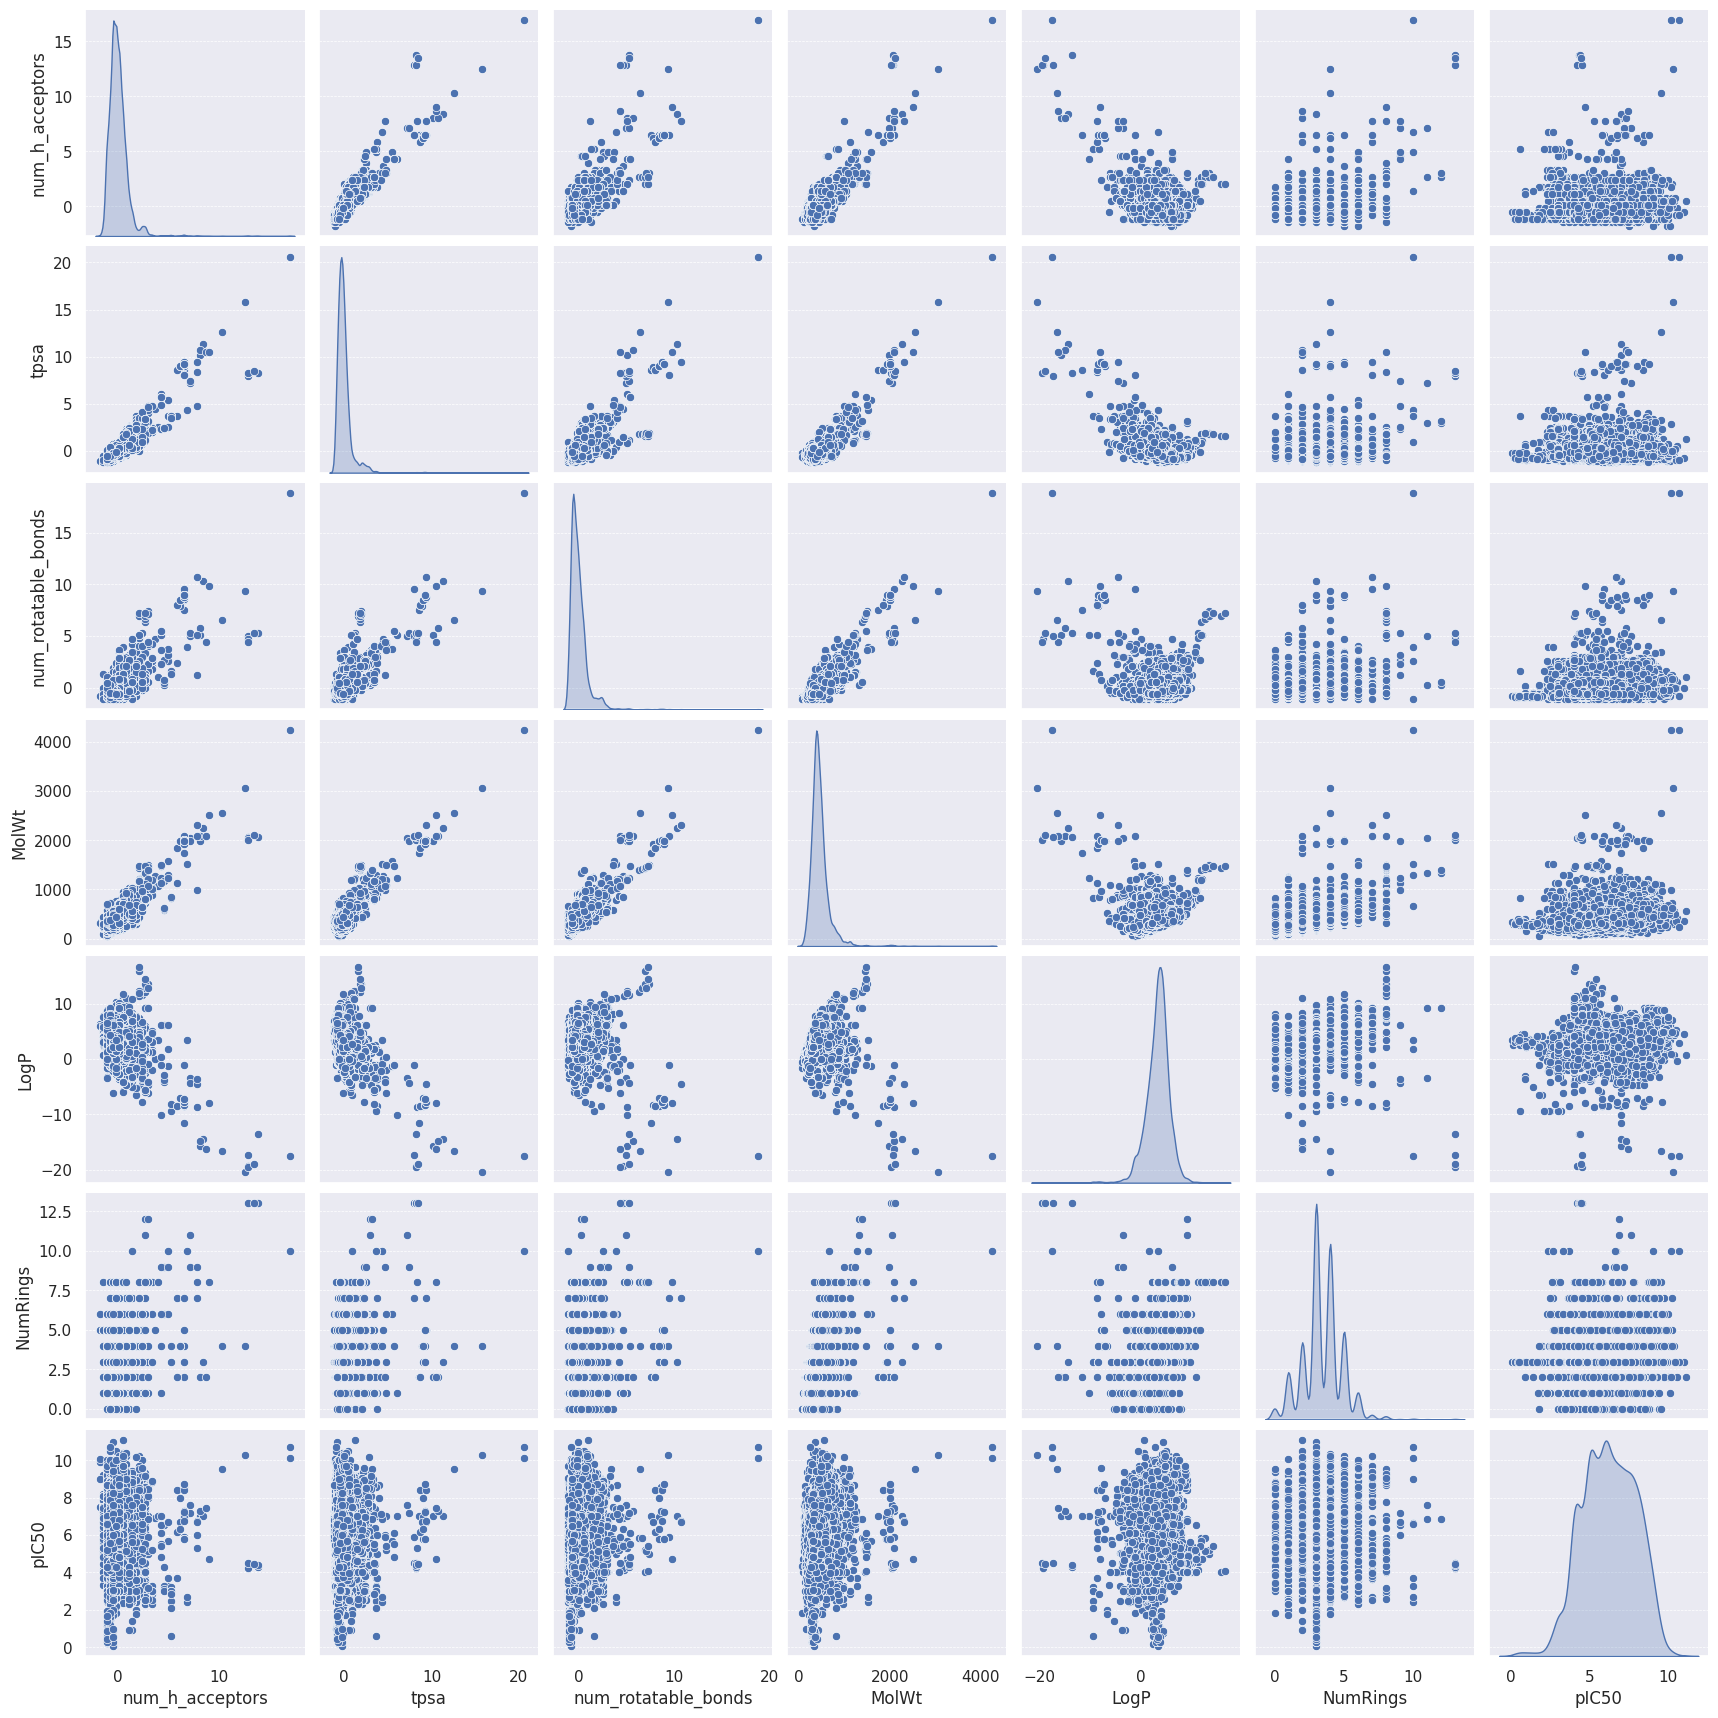

<Figure size 640x480 with 0 Axes>

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

num_cols = ['num_h_acceptors', 'tpsa', 'num_rotatable_bonds', 'MolWt', 'LogP', 'NumRings']

# Create the pairplot
pair_plot = sns.pairplot(df_modeling, vars=num_cols + ['pIC50'], diag_kind='kde')

# Loop over each subplot and adjust grid lines
for ax in pair_plot.axes.flatten():
    if ax is not None:
        ax.grid(axis='y', linestyle='--', linewidth=0.5)  # Enable only y-axis grid
        ax.grid(axis='x', visible=False)  # Disable x-axis grid

plt.show()
plt.savefig('pairplot.png')

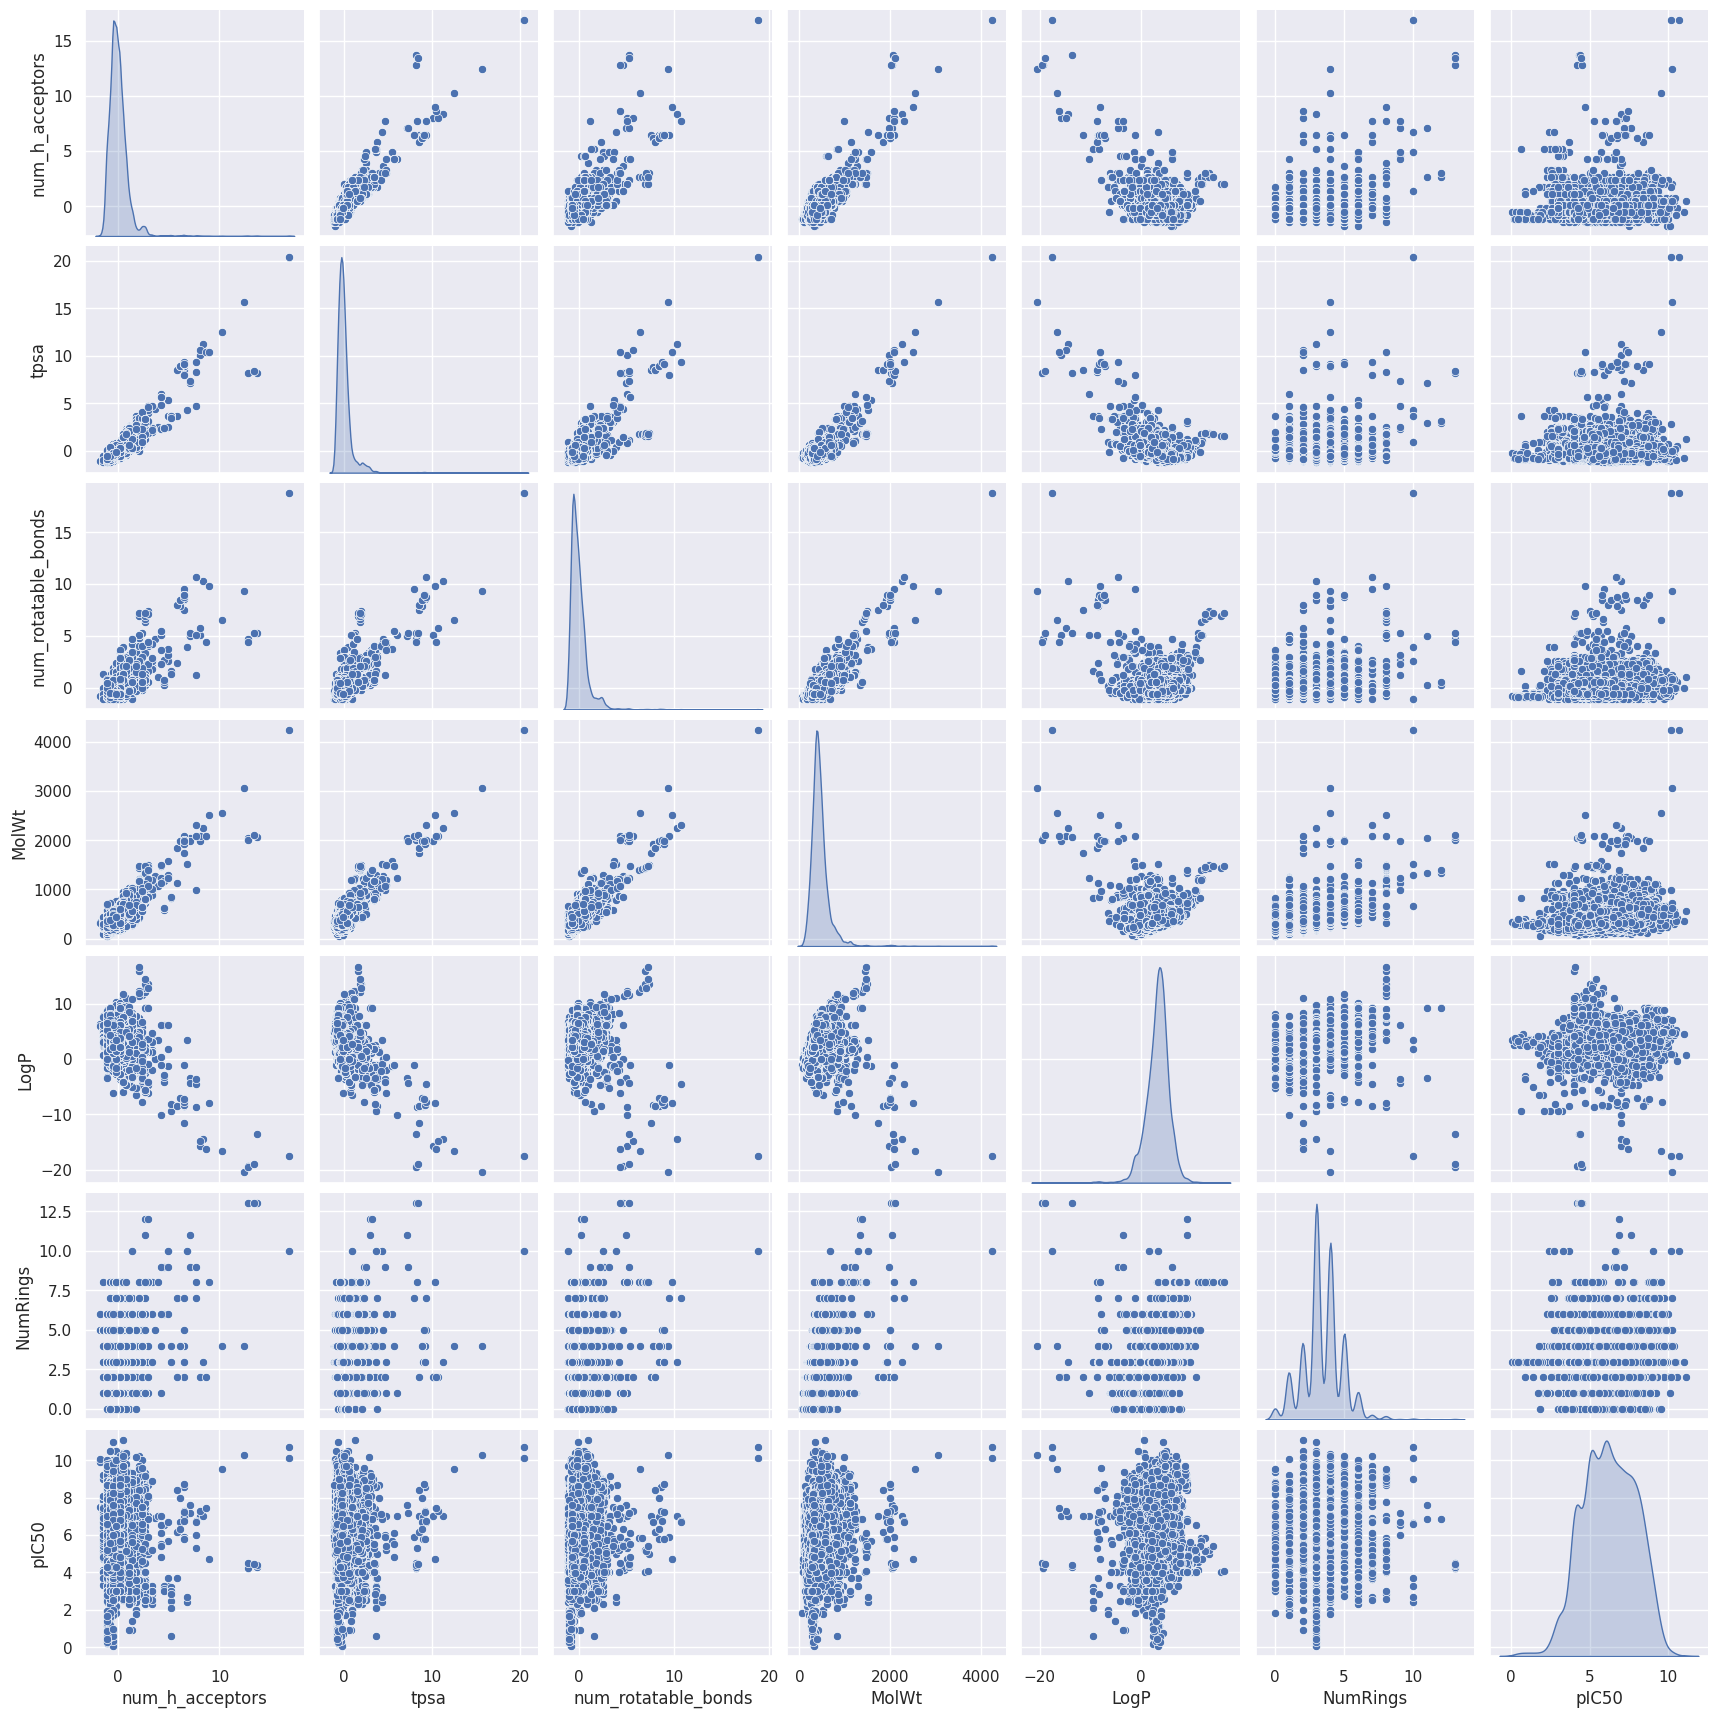

In [ ]:
# prompt: generate a pair plot and provide analysis based on the pairplot. The plot's first row should be pIC50. download a png file as well

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_updated is your DataFrame
num_cols = ['num_h_acceptors', 'tpsa', 'num_rotatable_bonds', 'MolWt', 'LogP', 'NumRings']
sns.pairplot(df_modeling, vars=num_cols + ['pIC50'], diag_kind='kde')
plt.savefig('pairplot.png')  # Save the plot as a PNG file
plt.show()

# Analysis based on the pairplot
# ... (Your analysis based on the pairplot)

# Example analysis:
# 1. pIC50 vs. Molecular Descriptors: You can identify which molecular descriptors exhibit a strong correlation with pIC50.
# 2. Relationships between Descriptors: You can see correlations between different molecular descriptors, which can help in understanding their interplay and impact on pIC50.
# 3. Outliers: Pair plots can help visualize any potential outliers in the data.
# 4. Density Distributions: The KDE plots on the diagonal show the distribution of each variable.
# 5. Note: The pair plot can help you understand potential relationships between variables, but it might not be conclusive. Further statistical analysis is needed to determine significant correlations.



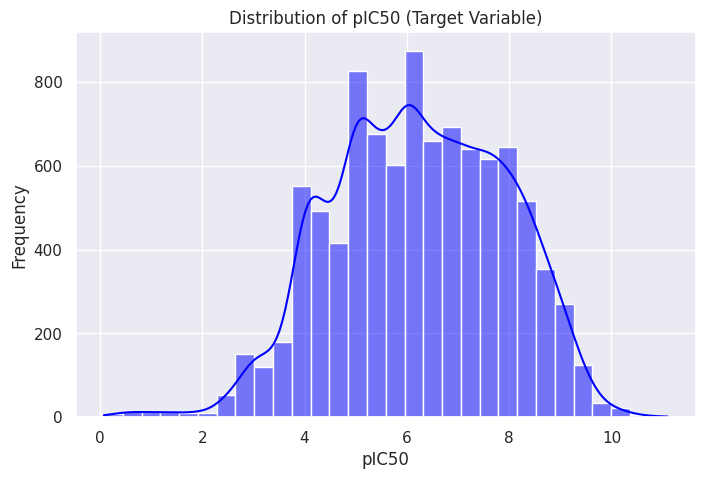

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.histplot(df_modeling['pIC50'], bins=30, kde=True, color='blue')
plt.title("Distribution of pIC50 (Target Variable)")
plt.xlabel("pIC50")
plt.ylabel("Frequency")
plt.show()

In [39]:
df_modeling.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9590 entries, 0 to 9589
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   molecule_chembl_id   9590 non-null   object 
 1   target_chembl_id     9590 non-null   int64  
 2   canonical_smiles     9590 non-null   object 
 3   standard_value       9590 non-null   float64
 4   pIC50                9590 non-null   float64
 5   assay_chembl_id      9590 non-null   int64  
 6   target_family        9590 non-null   int64  
 7   compound_class       9590 non-null   int64  
 8   toxicity_risk        9590 non-null   float64
 9   solubility_level     9590 non-null   float64
 10  num_h_acceptors      9590 non-null   float64
 11  tpsa                 9590 non-null   float64
 12  num_rotatable_bonds  9590 non-null   float64
 13  lipinski_compliant   9590 non-null   int64  
 14  MolWt                9590 non-null   float64
 15  LogP                 9590 non-null   f

In [ ]:
import plotly.express as px
df_modeling['Bioactivity_Class'] = df_cleaned['pIC50'].apply(lambda x: 'Active' if x >= 6 else 'Inactive')

In [ ]:
import plotly.express as px

fig = px.histogram(
    df_modeling,
    x="Bioactivity_Class",
    color="Bioactivity_Class",
    title="Active vs. Inactive Compounds",
    text_auto=True,
    color_discrete_sequence=["#1f77b4", "#4682b4"]  # Shades of blue
)

# Update layout for font and title styling
fig.update_layout(
    font=dict(
        family="Times New Roman",
        size=16
    ),
    title_font=dict(
        family="Times New Roman",
        size=20
    )
)

fig.show()

# Data Modeling

In [ ]:
drop_cols = ['molecule_chembl_id', 'canonical_smiles', 'assay_chembl_id', 'Bioactivity_Class','standard_value']
df_model = df_modeling.drop(columns=drop_cols)

In [ ]:
df_model.head()

target_chembl_id     pIC50  target_family  compound_class  toxicity_risk  \
0               252  5.602060            122               1       1.424118   
1               252  5.045757            122               0      -0.707222   
2                16  6.000000            268               0      -0.707222   
3               116  5.008774             81               1      -1.417668   
4               131  5.251812             82               1       0.713671   

   solubility_level  num_h_acceptors      tpsa  num_rotatable_bonds  \
0         -0.015402        -0.172441 -0.018634            -0.653665   
1         -0.723066         0.458973  0.201623            -0.198389   
2         -0.723066        -0.172441 -0.309167            -0.046630   
3          0.692262        -0.488148 -0.835348            -0.653665   
4          0.692262        -0.488148 -0.835348            -0.653665   

   lipinski_compliant    MolWt     LogP  NumRings  
0                   1  398.374  4.30202         5  
1                   0  520.497  5.67780         6  
2                   0  501.458  5.35090         4  
3                   1  342.446  3.37000         5  
4                   1  342.446  3.37000         5

In [ ]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9590 entries, 0 to 9589
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   target_chembl_id     9590 non-null   int64  
 1   pIC50                9590 non-null   float64
 2   target_family        9590 non-null   int64  
 3   compound_class       9590 non-null   int64  
 4   toxicity_risk        9590 non-null   float64
 5   solubility_level     9590 non-null   float64
 6   num_h_acceptors      9590 non-null   float64
 7   tpsa                 9590 non-null   float64
 8   num_rotatable_bonds  9590 non-null   float64
 9   lipinski_compliant   9590 non-null   int64  
 10  MolWt                9590 non-null   float64
 11  LogP                 9590 non-null   float64
 12  NumRings             9590 non-null   int64  
dtypes: float64(8), int64(5)
memory usage: 974.1 KB


In [ ]:
from sklearn.model_selection import train_test_split

# Step 1: Split off 1000 samples for the test set
X_temp, X_test, y_temp, y_test = train_test_split(
    df_model.drop(columns=['pIC50']),
    df_model['pIC50'],
    test_size=1000,
)

# Step 2: Split the remaining into train and validation sets (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.2,
    random_state=42
)

# Base Modeling

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance

import shap
import warnings
warnings.filterwarnings("ignore")

##Ridge Regression model

In [ ]:
alphas = [0.01, 0.1, 1, 10, 100]
ridge = Ridge()
ridge_cv = GridSearchCV(ridge, {'alpha': alphas}, cv=5, scoring='neg_mean_squared_error')
ridge_cv.fit(X_train, y_train)

print("Best Alpha:", ridge_cv.best_params_['alpha'])

Best Alpha: 100


In [86]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Best model from RidgeCV
ridge_best = ridge_cv.best_estimator_

# Predictions
y_pred_train = ridge_best.predict(X_train)
y_pred_val = ridge_best.predict(X_val)
y_pred_test = ridge_best.predict(X_test)

# === Goodness of Fit on Training Set ===
print("\033[1mTraining Set (Goodness of Fit):\033[0m")
print("R² Score:", r2_score(y_train, y_pred_train))
print("RMSE:", np.sqrt(mean_squared_error(y_train, y_pred_train)))
print("MAE:", mean_absolute_error(y_train, y_pred_train))
print()

# === Validation Set (Generalization Performance) ===
print("\033[1mValidation Set:\033[0m")
print("RMSE:", np.sqrt(mean_squared_error(y_val, y_pred_val)))
print("MAE:", mean_absolute_error(y_val, y_pred_val))
print()

# === Test Set (Final Evaluation) ===
print("\033[1mTest Set:\033[0m")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_test)))
print("MAE:", mean_absolute_error(y_test, y_pred_test))


Training Set (Goodness of Fit):
R² Score: 0.08539418838760171
RMSE: 1.607154121875036
MAE: 1.3289155512062059

Validation Set:
RMSE: 1.58182480016749
MAE: 1.3161347791307385

Test Set:
RMSE: 1.6277417775866279
MAE: 1.347039438770219


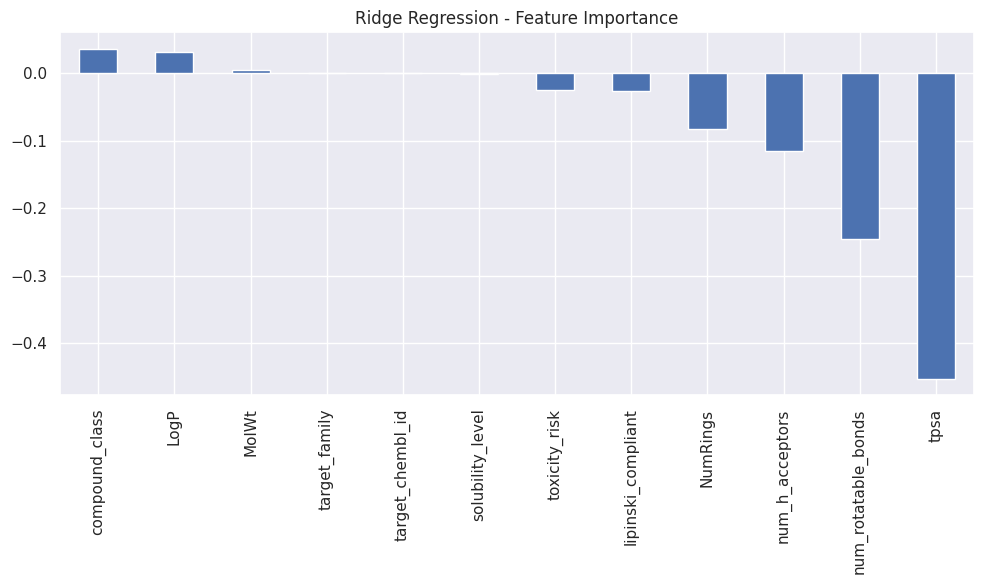

In [87]:
ridge_importance = pd.Series(ridge_best.coef_, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
ridge_importance.plot(kind='bar')
plt.title("Ridge Regression - Feature Importance")
plt.tight_layout()
plt.show()

## Randomforest Regressor model

In [88]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, max_depth=None, random_state=42)
rf_model.fit(X_train, y_train)


# Predictions
y_pred_rf_train = rf_model.predict(X_train)
y_pred_rf_val = rf_model.predict(X_val)
y_pred_rf_test = rf_model.predict(X_test)

print("Random Forest Base Model")
# === Goodness of Fit on Training Set ===
print("\033[1mTraining Set (Goodness of Fit):\033[0m")
print("R² Score:", r2_score(y_train, y_pred_rf_train))
print("RMSE:", np.sqrt(mean_squared_error(y_train, y_pred_rf_train)))
print("MAE:", mean_absolute_error(y_train, y_pred_rf_train))
print()

# === Validation Set (Generalization Performance) ===
print("\033[1mValidation Set:\033[0m")
print("RMSE:", np.sqrt(mean_squared_error(y_val, y_pred_rf_val)))
print("MAE:", mean_absolute_error(y_val, y_pred_rf_val))
print("R² Score:", r2_score(y_val, y_pred_rf_val))
print()

# === Test Set (Final Evaluation) ===
print("\033[1mTest Set:\033[0m")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf_test)))
print("MAE:", mean_absolute_error(y_test, y_pred_rf_test))
print("R² Score:", r2_score(y_test, y_pred_rf_test))

Random Forest Base Model
Training Set (Goodness of Fit):
R² Score: 0.954324886964143
RMSE: 0.3591537154212516
MAE: 0.2660104736242241

Validation Set:
RMSE: 0.95428685279621
MAE: 0.7182371837184425
R² Score: 0.6670549014817965

Test Set:
RMSE: 0.9403570366407449
MAE: 0.7036665310682959
R² Score: 0.6910723345971542


## Multi Layer Perceptron model

In [89]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Train the MLP Regressor
mlp = MLPRegressor(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
mlp.fit(X_train, y_train)

# Predictions
y_pred_mlp_train = mlp.predict(X_train)
y_pred_mlp_val = mlp.predict(X_val)
y_pred_mlp_test = mlp.predict(X_test)

# === Goodness of Fit on Training Set ===
print("\033[1mTraining Set (Goodness of Fit):\033[0m")
print("R² Score:", r2_score(y_train, y_pred_mlp_train))
print("RMSE:", np.sqrt(mean_squared_error(y_train, y_pred_mlp_train)))
print("MAE:", mean_absolute_error(y_train, y_pred_mlp_train))
print()

# === Validation Set (Generalization Performance) ===
print("\033[1mValidation Set:\033[0m")
print("RMSE:", np.sqrt(mean_squared_error(y_val, y_pred_mlp_val)))
print("MAE:", mean_absolute_error(y_val, y_pred_mlp_val))
print("R² Score:", r2_score(y_val, y_pred_mlp_val))
print()

# === Test Set (Final Evaluation) ===
print("\033[1mTest Set:\033[0m")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_mlp_test)))
print("MAE:", mean_absolute_error(y_test, y_pred_mlp_test))
print("R² Score:", r2_score(y_test, y_pred_mlp_test))


Training Set (Goodness of Fit):
R² Score: 0.15874145650228666
RMSE: 1.5413642861030912
MAE: 1.2367972956420168

Validation Set:
RMSE: 1.5836763475932645
MAE: 1.2783302514778188
R² Score: 0.08304588119209233

Test Set:
RMSE: 1.5668769286678639
MAE: 1.266244878976147
R² Score: 0.14228892714877017


##XGBoost Model

In [90]:
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

# Train the model
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)

# Predictions
y_pred_xgb_train = xgb_model.predict(X_train)
y_pred_xgb_val = xgb_model.predict(X_val)
y_pred_xgb_test = xgb_model.predict(X_test)

# === Goodness of Fit on Training Set ===
print("\033[1mTraining Set (Goodness of Fit):\033[0m")
print("R² Score:", r2_score(y_train, y_pred_xgb_train))
print("RMSE:", np.sqrt(mean_squared_error(y_train, y_pred_xgb_train)))
print("MAE:", mean_absolute_error(y_train, y_pred_xgb_train))
print()

# === Validation Set (Generalization Performance) ===
print("\033[1mValidation Set:\033[0m")
print("RMSE:", np.sqrt(mean_squared_error(y_val, y_pred_xgb_val)))
print("MAE:", mean_absolute_error(y_val, y_pred_xgb_val))
print("R² Score:", r2_score(y_val, y_pred_xgb_val))
print()

# === Test Set (Final Evaluation) ===
print("\033[1mTest Set:\033[0m")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb_test)))
print("MAE:", mean_absolute_error(y_test, y_pred_xgb_test))
print("R² Score:", r2_score(y_test, y_pred_xgb_test))

Training Set (Goodness of Fit):
R² Score: 0.8941301126948071
RMSE: 0.546797818862705
MAE: 0.40958681878327435

Validation Set:
RMSE: 0.975733541232931
MAE: 0.7445821425623564
R² Score: 0.651921488447593

Test Set:
RMSE: 0.9686053782494806
MAE: 0.7239143328348803
R² Score: 0.6722331726573743


##Error Distribution

In [ ]:
import plotly.figure_factory as ff
import numpy as np

# Replace with your actual data
# y_val = true values
# y_pred_ridge_base, y_pred_rf_base, y_pred_mlp_base, y_pred_xgboost_base = predictions


# Compute residuals
residual_ridge = y_val - y_pred_val
residual_rf = y_val - y_pred_rf_val
residual_mlp = y_val - y_pred_mlp_val
residual_xgb = y_val - y_pred_xgb_val

# Organize data and labels
residual_data = [residual_ridge, residual_rf, residual_mlp, residual_xgb]
group_labels = ['Ridge', 'Random Forest', 'MLP', 'XGBoost']
colors = ['cornflowerblue', 'royalblue', 'skyblue', 'deepskyblue']

# Create KDE-style plot
fig = ff.create_distplot(
    residual_data,
    group_labels,
    show_hist=False,
    show_rug=False,
    colors=colors
)

# Update layout
fig.update_layout(
    title='Residual Error Distribution (Baseline Models)',
    xaxis_title='Residual (Actual - Predicted)',
    yaxis_title='Density',
    font=dict(family='Times New Roman', size=14),
    template='plotly_white'
)

fig.show()

In [ ]:
import plotly.figure_factory as ff
import numpy as np


# Compute residuals
residual_ridge = y_test - y_pred_test
residual_rf = y_test - y_pred_rf_test
residual_mlp = y_test - y_pred_mlp_test
residual_xgb = y_test - y_pred_xgb_test

# Organize data and labels
residual_data = [residual_ridge, residual_rf, residual_mlp, residual_xgb]
group_labels = ['Ridge', 'Random Forest', 'MLP', 'XGBoost']
colors = ['cornflowerblue', 'royalblue', 'skyblue', 'deepskyblue']

# Create KDE-style plot
fig = ff.create_distplot(
    residual_data,
    group_labels,
    show_hist=False,
    show_rug=False,
    colors=colors
)

# Update layout
fig.update_layout(
    title='Residual Error Distribution (Baseline Models)',
    xaxis_title='Residual (Actual - Predicted)',
    yaxis_title='Density',
    font=dict(family='Times New Roman', size=14),
    template='plotly_white'
)

fig.show()
fig.write_image("residual_distribution_test_set.png")

# Hyper Tuned Parameters modeling

## Tuned RandomForest

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 150,300],
    'max_depth': [None, 5, 6,10],
}

rf = RandomForestRegressor(random_state=42)
grid_search_rf = GridSearchCV(rf, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

best_rf = grid_search_rf.best_estimator_
print("Best Params:", grid_search_rf.best_params_)

# Evaluate best model

#predictions
y_pred_best_rf_train = best_rf.predict(X_train)
y_pred_best_rf_val = best_rf.predict(X_val)
y_pred_best_rf_test = best_rf.predict(X_test)


print(f"Tuned Random Forest Regressor:")

#=== Goodness of Fit ======#
print("\033[1mTraining Set (Goodness of Fit):\033[0m")
best_rf_r2_train = r2_score(y_train, y_pred_best_rf_train)
print("R² Score:", best_rf_r2_train)
print()

# === Validation Set (Generalization Performance) ===
print("\033[1mValidation Set:\033[0m")
print("RMSE:", np.sqrt(mean_squared_error(y_val, y_pred_best_rf_val)))
print("MAE:", mean_absolute_error(y_val, y_pred_best_rf_val))
print("R² Score:", r2_score(y_val, y_pred_best_rf_val))
print()

# === Test Set (Final Evaluation) ===
print("\033[1mTest Set:\033[0m")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_best_rf_test)))
print("MAE:", mean_absolute_error(y_test, y_pred_best_rf_test))
print("R² Score:", r2_score(y_test, y_pred_best_rf_test))

Best Params: {'max_depth': None, 'n_estimators': 300}
Tuned Random Forest Regressor:
Training Set (Goodness of Fit):
R² Score: 0.9559211619530216

Validation Set:
RMSE: 0.9564723541818506
MAE: 0.7178724145270793
R² Score: 0.6655281379014992

Test Set:
RMSE: 0.9342476913505435
MAE: 0.6982888320647236
R² Score: 0.6950733997596474


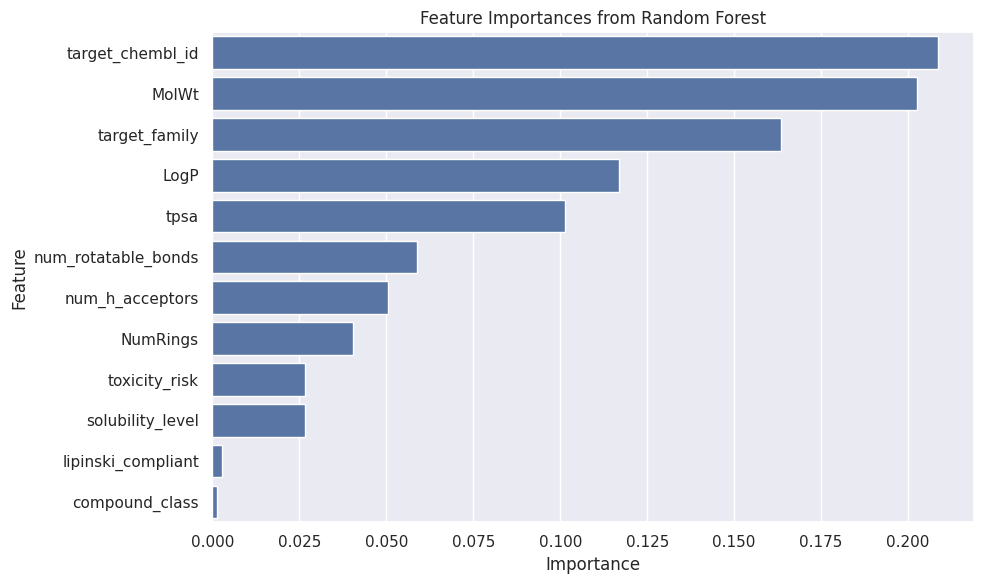

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot feature importances
importances = best_rf.feature_importances_
features = X_train.columns

feat_imp_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df)
plt.title('Feature Importances from Random Forest')
plt.tight_layout()
plt.show()

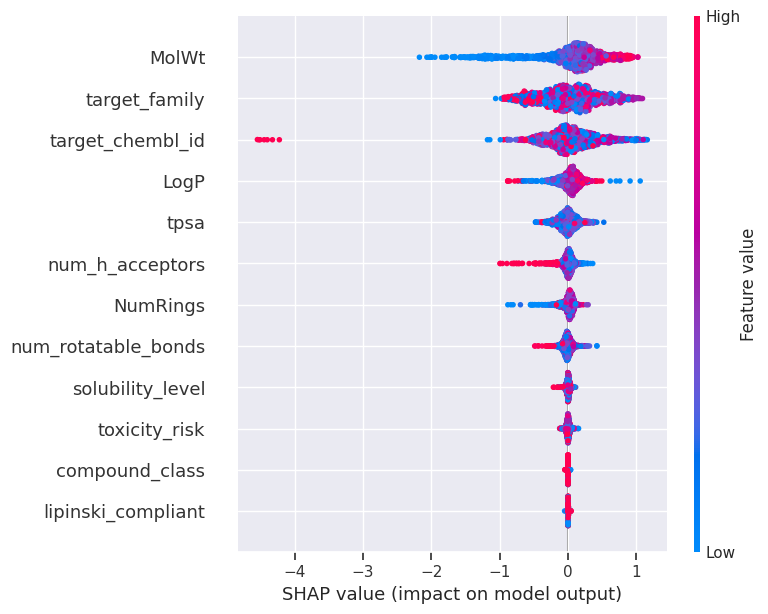

In [ ]:
import shap

# Initialize the SHAP TreeExplainer
explainer = shap.Explainer(best_rf)

# Calculate SHAP values for validation set
shap_values = explainer(X_val)
# Global feature importance
shap.summary_plot(shap_values, X_val)

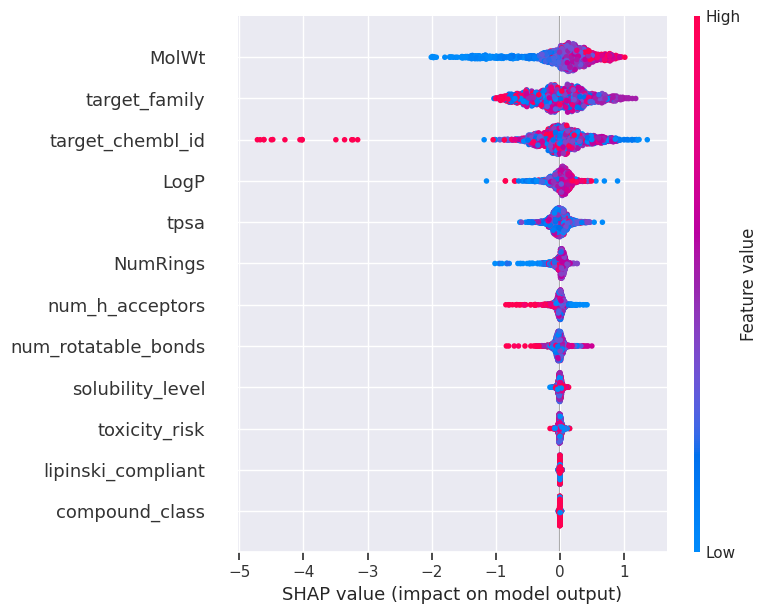

In [78]:
import shap
import matplotlib.pyplot as plt

# Calculate SHAP values
explainer = shap.Explainer(best_rf)
shap_values = explainer(X_val)


shap.summary_plot(shap_values, X_val, show=False)

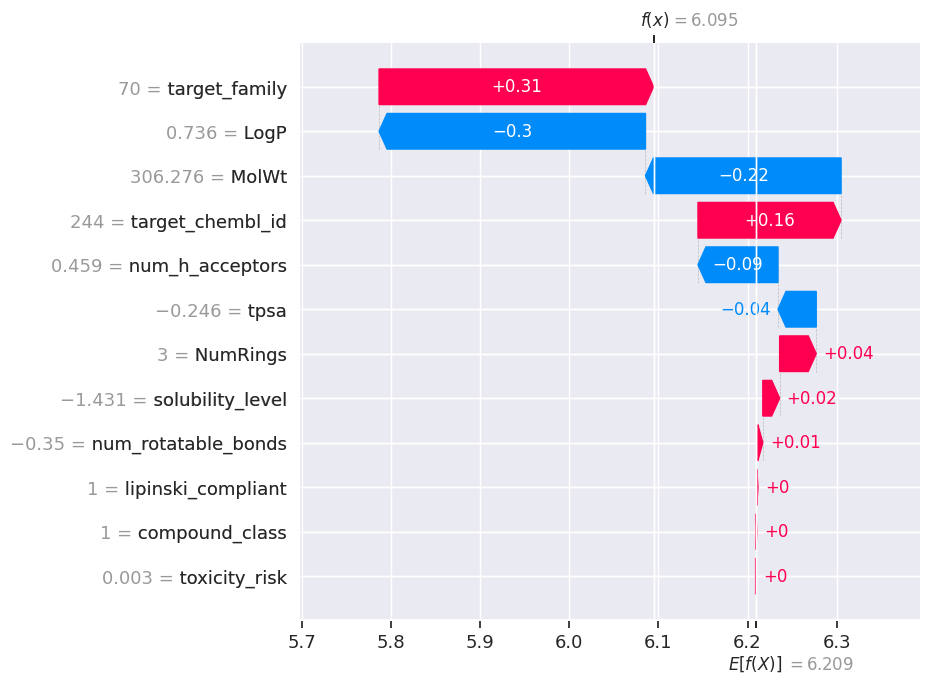

In [ ]:
import shap

# Explain the model on the full dataset
#explainer = shap.Explainer(best_rf, X_val)
#shap_values = explainer(X_val)

# Choose an instance (e.g., 0th sample)
sample_idx = 0

# Waterfall plot for one instance
shap.plots.waterfall(shap_values[sample_idx], max_display=12)

## Tuned XGBoost

In [79]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7]
}

# Set up the model
xgb = XGBRegressor(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid,
                           scoring='r2', cv=3, verbose=1, n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Best estimator and params
print("Best Parameters:", grid_search.best_params_)

# Predict using the best estimator
best_model_xgboost = grid_search.best_estimator_
y_pred_best_xg_train = best_model_xgboost.predict(X_train)
y_pred_best_xg_val = best_model_xgboost.predict(X_val)
y_pred_best_xg_test = best_model_xgboost.predict(X_test)

print(f"Tuned XGBoost Regressor:")

#=== Goodness of Fit ======#
print("\033[1mTraining Set (Goodness of Fit):\033[0m")
best_xg_r2_train = r2_score(y_train, y_pred_best_xg_train)
print("R² Score:", best_xg_r2_train)
print()

# === Validation Set (Generalization Performance) ===
print("\033[1mValidation Set:\033[0m")
print("RMSE:", np.sqrt(mean_squared_error(y_val, y_pred_best_xg_val)))
print("MAE:", mean_absolute_error(y_val, y_pred_best_xg_val))
print("R² Score:", r2_score(y_val, y_pred_best_xg_val))
print()

# === Test Set (Final Evaluation) ===
print("\033[1mTest Set:\033[0m")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_best_xg_test)))
print("MAE:", mean_absolute_error(y_test, y_pred_best_xg_test))
print("R² Score:", r2_score(y_test, y_pred_best_xg_test))

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300}
Tuned XGBoost Regressor:
Training Set (Goodness of Fit):
R² Score: 0.9378118766037161

Validation Set:
RMSE: 0.9355967374704037
MAE: 0.7101889890399709
R² Score: 0.6799689311508245

Test Set:
RMSE: 0.9381720443142094
MAE: 0.6874434292127596
R² Score: 0.6925063013553296


In [80]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np

# Extract cv_results_ from grid search
cv_results = grid_search.cv_results_
df = pd.DataFrame({
    'n_estimators': cv_results['param_n_estimators'].astype(int),
    'learning_rate': cv_results['param_learning_rate'].astype(float),
    'max_depth': cv_results['param_max_depth'].astype(int),
    'error_metric': 1 - cv_results['mean_test_score']  # If scoring='r2'
})

# Normalize error metric to [0, 1]
normed = (df['error_metric'] - df['error_metric'].min()) / (df['error_metric'].max() - df['error_metric'].min())

# Identify the best-performing model index and normalized value
best_idx = grid_search.best_index_
best_norm_val = normed.iloc[best_idx]

# Build a clean custom colorscale that includes a red spike for the best
# Force it to have unique and sorted values
colorscale = [
    [0.0, 'rgb(198,219,239)'],
    [max(0.0, best_norm_val - 0.001), 'rgb(33,113,181)'],
    [best_norm_val, 'red'],
    [min(1.0, best_norm_val + 0.001), 'rgb(33,113,181)'],
    [1.0, 'rgb(8,48,107)']
]

# Plot
fig = go.Figure(data=go.Parcoords(
    line=dict(color=normed, colorscale=colorscale, showscale=True),
    dimensions=[
        dict(label='n_estimators', values=df['n_estimators']),
        dict(label='learning_rate', values=df['learning_rate']),
        dict(label='max_depth', values=df['max_depth']),
        dict(label='error_metric', values=df['error_metric']),
    ]
))

fig.update_layout(title="Hyperparameter tuning for XGBoost")
fig.show()

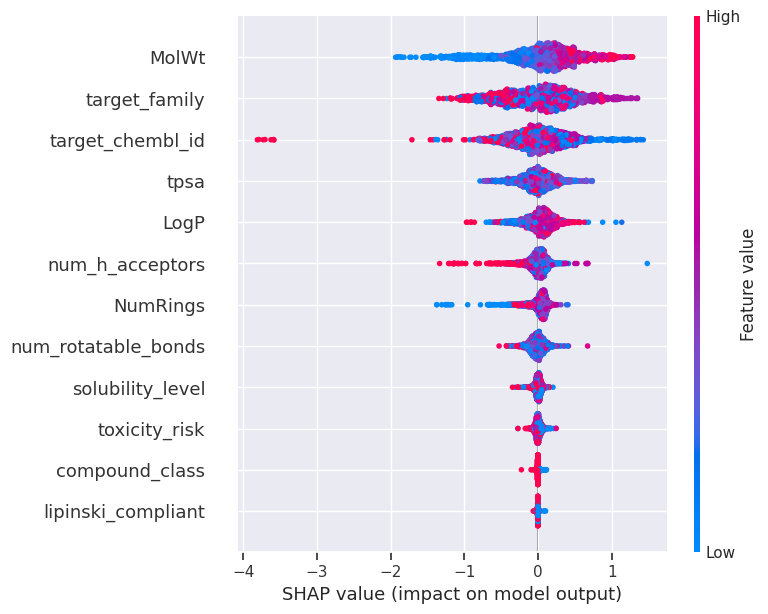

In [ ]:
import shap

# Initialize the SHAP TreeExplainer
explainer = shap.Explainer(best_model_xgboost)

# Calculate SHAP values for validation set
shap_values = explainer(X_val)
# Global feature importance
shap.summary_plot(shap_values, X_val)


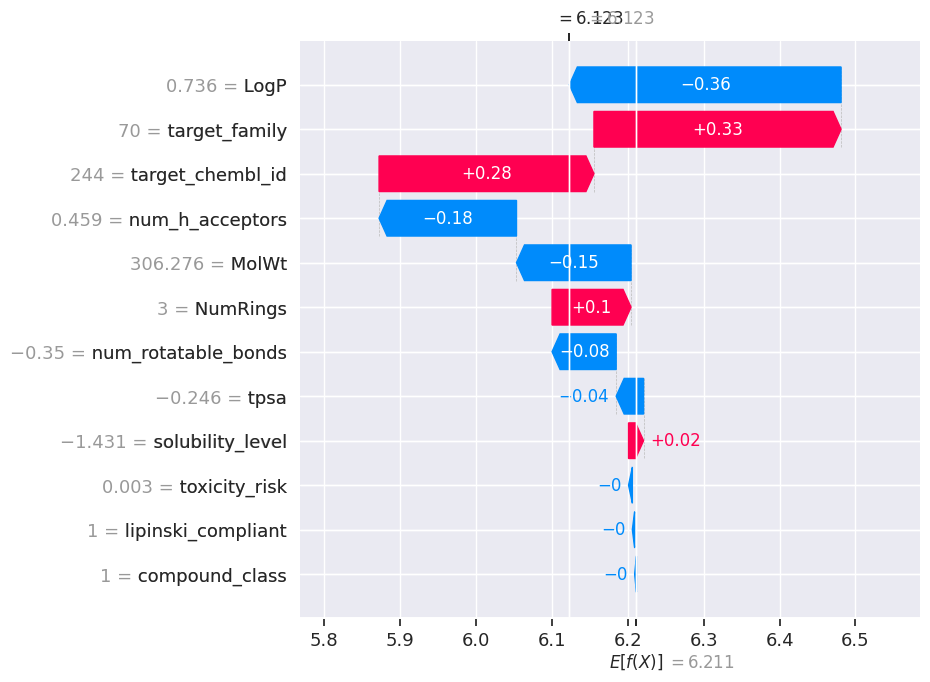

In [ ]:
# Choose an instance (e.g., 0th sample)
sample_idx = 0

# Waterfall plot for one instance
shap.plots.waterfall(shap_values[sample_idx], max_display=12)

## Tuned MLP Model

In [82]:
param_grid = {
    'hidden_layer_sizes': [(100,), (64, 32), (128, 64)],
    'alpha': [0.0001, 0.001, 0.01]
}

from sklearn.model_selection import GridSearchCV

mlp_model = MLPRegressor(max_iter=500, random_state=42)
grid_search_mlp = GridSearchCV(mlp_model, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_mlp.fit(X_train, y_train)

# Best model
best_mlp = grid_search_mlp.best_estimator_
print("Best Params:", grid_search_mlp.best_params_)

# Evaluate
y_pred_best_mlp_train = best_mlp.predict(X_train)
y_pred_best_mlp_test = best_mlp.predict(X_test)
y_pred_best_mlp_val = best_mlp.predict(X_val)

print(f"Tuned MLP Regressor:")
#=== Goodness of Fit ======#
print("\033[1mTraining Set (Goodness of Fit):\033[0m")
best_xg_r2_train = r2_score(y_train, y_pred_best_mlp_train)
print("R² Score:", best_xg_r2_train)
print()

# === Validation Set (Generalization Performance) ===
print("\033[1mValidation Set:\033[0m")
print("RMSE:", np.sqrt(mean_squared_error(y_val, y_pred_best_mlp_val)))
print("MAE:", mean_absolute_error(y_val, y_pred_best_mlp_val))
print("R² Score:", r2_score(y_val, y_pred_best_mlp_val))
print()

# === Test Set (Final Evaluation) ===
print("\033[1mTest Set:\033[0m")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_best_mlp_test)))
print("MAE:", mean_absolute_error(y_test, y_pred_best_mlp_test))
print("R² Score:", r2_score(y_test, y_pred_best_mlp_test))

Best Params: {'alpha': 0.001, 'hidden_layer_sizes': (100,)}
Tuned MLP Regressor:
Training Set (Goodness of Fit):
R² Score: 0.14949204173352215

Validation Set:
RMSE: 1.590131994467208
MAE: 1.283762923029981
R² Score: 0.07555496034364106

Test Set:
RMSE: 1.5755248698190796
MAE: 1.2727969716552805
R² Score: 0.13279500458156324


In [83]:
import plotly.figure_factory as ff
import numpy as np

residual_rf = y_val - y_pred_best_rf_val
residual_mlp = y_val - y_pred_best_mlp_val
residual_xgb = y_val - y_pred_best_xg_val

# Grouped data and labels
residual_data = [residual_rf, residual_mlp, residual_xgb]
group_labels = ['Random Forest', 'MLP', 'XGBoost']

# Colors for a blue-themed plot
colors = ['royalblue', 'skyblue', 'deepskyblue']

# Create KDE plot
fig = ff.create_distplot(
    residual_data,
    group_labels,
    show_hist=False,
    show_rug=False,
    colors=colors
)

# Customize layout
fig.update_layout(
    title='Residual Error Distribution',
    xaxis_title='Residual (Actual - Predicted)',
    yaxis_title='Density',
    font=dict(family='Times New Roman', size=14),
    template='plotly_white'
)

fig.show()
fig.write_image("residual_distribution_tuned_validation_set.png")

## Analysis


# Feature Engineering to increase the predictive performance

In [42]:
df = pd.read_csv("chemb_data_with_new_descriptors.csv")

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9590 entries, 0 to 9589
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   molecule_chembl_id   9590 non-null   object 
 1   target_chembl_id     9590 non-null   int64  
 2   canonical_smiles     9590 non-null   object 
 3   standard_value       9590 non-null   float64
 4   pIC50                9590 non-null   float64
 5   assay_chembl_id      9590 non-null   int64  
 6   target_family        9590 non-null   int64  
 7   compound_class       9590 non-null   int64  
 8   toxicity_risk        9590 non-null   float64
 9   solubility_level     9590 non-null   float64
 10  num_h_acceptors      9590 non-null   float64
 11  tpsa                 9590 non-null   float64
 12  num_rotatable_bonds  9590 non-null   float64
 13  lipinski_compliant   9590 non-null   int64  
 14  MolWt                9590 non-null   float64
 15  LogP                 9590 non-null   f

In [ ]:
df_new = pd.read_csv("chembl_enhanced_dataset_complete.csv")

In [ ]:
df_new = df_new.drop(columns=['organism','assay_type','num_h_donors'])

In [ ]:
# Drop rows with missing SMILES (since it's crucial for molecular representation)
df_new.dropna(subset=['canonical_smiles'], inplace=True)

In [ ]:
df_new = df_new[df_new['pIC50']>0]

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode categorical variables
categorical_cols = ['target_chembl_id','assay_chembl_id', 'compound_class', 'target_family']
for col in categorical_cols:
    le = LabelEncoder()
    df_new[col] = le.fit_transform(df_new[col])

from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import StandardScaler

# Define numerical features
num_cols = ['toxicity_risk', 'solubility_level', 'num_h_acceptors', 'tpsa', 'num_rotatable_bonds']

# Apply Standard Scaling
scaler = StandardScaler()
df_new[num_cols] = scaler.fit_transform(df_new[num_cols])

In [ ]:
from rdkit import Chem
from rdkit.Chem import Descriptors

# Function to compute molecular descriptors
def compute_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return {
            'MolWt': Descriptors.MolWt(mol),  # Molecular weight
            'LogP': Descriptors.MolLogP(mol),  # LogP (Lipophilicity)
            'NumRings': Chem.rdMolDescriptors.CalcNumRings(mol),  # Number of rings
        }
    else:
        return None

# Apply function to dataset
mol_features_Test = df_new['canonical_smiles'].apply(lambda x: compute_descriptors(x) if pd.notnull(x) else None)
mol_features_df_test = pd.DataFrame(mol_features_Test.tolist())

# Merge extracted features
df_new = pd.concat([df_new, mol_features_df_test], axis=1)

In [ ]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9605 entries, 0 to 5795
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   molecule_chembl_id   9590 non-null   object 
 1   target_chembl_id     9590 non-null   float64
 2   canonical_smiles     9590 non-null   object 
 3   standard_value       9590 non-null   float64
 4   pIC50                9590 non-null   float64
 5   assay_chembl_id      9590 non-null   float64
 6   target_family        9590 non-null   float64
 7   compound_class       9590 non-null   float64
 8   toxicity_risk        9590 non-null   float64
 9   solubility_level     9590 non-null   float64
 10  num_h_acceptors      9590 non-null   float64
 11  tpsa                 9590 non-null   float64
 12  num_rotatable_bonds  9590 non-null   float64
 13  lipinski_compliant   9590 non-null   float64
 14  MolWt                9590 non-null   float64
 15  LogP                 9590 non-null   float6

## Generating morgan fingerprints based on the canonical smiles

In [44]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem

# Function to convert SMILES to ECFP4 fingerprint
def smiles_to_ecfp4(smiles, n_bits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.zeros(n_bits)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=512)  # or 1024
    return np.array(fp)

# Generate fingerprints
print("Generating fingerprints...")
fp_list = df['canonical_smiles'].apply(smiles_to_ecfp4)
fp_array = np.stack(fp_list.values)

# Create DataFrame for fingerprints
fp_df = pd.DataFrame(fp_array, columns=[f'FP_{i}' for i in range(fp_array.shape[1])])

# Combine original data with fingerprints
output_df = pd.concat([df.reset_index(drop=True), fp_df], axis=1)

# Save to new CSV
output_df.to_csv("chembl_with_512fingerprints.csv", index=False)
print("Done! File saved as 'chembl_with_512fingerprints.csv'")

Generating fingerprints...


Streaming output truncated to the last 5000 lines.
[15:40:00] DEPRECATION WARNING: please use MorganGenerator
[15:40:00] DEPRECATION WARNING: please use MorganGenerator
[15:40:00] DEPRECATION WARNING: please use MorganGenerator
[15:40:00] DEPRECATION WARNING: please use MorganGenerator
[15:40:00] DEPRECATION WARNING: please use MorganGenerator
[15:40:00] DEPRECATION WARNING: please use MorganGenerator
[15:40:00] DEPRECATION WARNING: please use MorganGenerator
[15:40:00] DEPRECATION WARNING: please use MorganGenerator
[15:40:00] DEPRECATION WARNING: please use MorganGenerator
[15:40:00] DEPRECATION WARNING: please use MorganGenerator
[15:40:00] DEPRECATION WARNING: please use MorganGenerator
[15:40:00] DEPRECATION WARNING: please use MorganGenerator
[15:40:00] DEPRECATION WARNING: please use MorganGenerator
[15:40:00] DEPRECATION WARNING: please use MorganGenerator
[15:40:00] DEPRECATION WARNING: please use MorganGenerator
[15:40:00] DEPRECATION WARNING: please use MorganGenerator
[15:4

Done! File saved as 'chembl_with_512fingerprints.csv'


# Feature extraction after adding fingerprints

In [94]:
drop_cols = ['molecule_chembl_id', 'canonical_smiles', 'assay_chembl_id']
output_df = output_df.drop(columns=drop_cols)

In [95]:
output_df.head()

target_chembl_id  standard_value     pIC50  target_family  compound_class  \
0                 9        100000.0  4.000000             73               1   
1               256          2500.0  5.602060            122               1   
2               256          9000.0  5.045757            122               0   
3               113            29.4  7.531653             20               1   
4                16          1000.0  6.000000            270               0   

   toxicity_risk  solubility_level  num_h_acceptors      tpsa  \
0       0.006891         -1.428072        -0.487504 -0.601336   
1       1.428008         -0.014592        -0.170715 -0.015548   
2      -0.703668         -0.721332         0.462861  0.206726   
3       0.717449         -0.721332        -0.487504 -0.579782   
4      -0.703668         -0.721332        -0.170715 -0.308743   

   num_rotatable_bonds  ...  FP_502  FP_503  FP_504  FP_505  FP_506  FP_507  \
0            -0.807341  ...       0       0       0       0       0       0   
1            -0.655133  ...       0       0       0       0       0       0   
2            -0.198506  ...       0       0       0       0       0       1   
3            -0.350715  ...       1       0       0       0       0       0   
4            -0.046297  ...       0       1       1       0       0       0   

   FP_508  FP_509  FP_510  FP_511  
0       0       0       0       0  
1       0       1       0       0  
2       0       1       0       0  
3       0       0       0       0  
4       0       0       0       1  

[5 rows x 526 columns]

In [96]:
output_df = output_df.drop(columns = ['standard_value'])

# Data Modelling with fingerprints

In [98]:
from sklearn.model_selection import train_test_split
X_fp = output_df.drop(columns=['pIC50'])
y_fp = output_df['pIC50']
# Step 1: Create the test set (1000 samples)
X_temp_fp, X_test_fp, y_temp_fp, y_test_fp = train_test_split(
    X_fp, y_fp, test_size=1000
)

# Step 2: Split the remaining data into train and validation sets (e.g., 80-20 split)
X_train_fp, X_val_fp, y_train_fp, y_val_fp = train_test_split(
    X_temp_fp, y_temp_fp, test_size=0.2, random_state=42
)


## Ridge Regression with fingerprint

In [99]:
alphas = [0.01, 0.1, 1, 10, 100]
ridge = Ridge()
ridge_cv = GridSearchCV(ridge, {'alpha': alphas}, cv=5, scoring='neg_mean_squared_error')
ridge_cv.fit(X_train_fp, y_train_fp)

print("Best Alpha:", ridge_cv.best_params_['alpha'])

Best Alpha: 100


In [111]:
ridge_best = ridge_cv.best_estimator_
y_pred_ridge_fp = ridge_best.predict(X_val_fp)
y_pred_best_ridge_fp_train = ridge_best.predict(X_train_fp)
y_pred_best_ridge_fp_val = ridge_best.predict(X_val_fp)
y_pred_best_ridge_fp_test = ridge_best.predict(X_test_fp)
print("Tuned Ridge Regression:")

# === Goodness of Fit on Training Set ===
print("\033[1mTraining Set (Goodness of Fit):\033[0m")
print("R² Score:", r2_score(y_train_fp, y_pred_ridge_fp_train))
print("RMSE:", np.sqrt(mean_squared_error(y_train_fp, y_pred_ridge_fp_train)))
print("MAE:", mean_absolute_error(y_train_fp, y_pred_ridge_fp_train))
print()

# === Validation Set (Generalization Performance) ===
print("\033[1mValidation Set:\033[0m")
print("RMSE:", np.sqrt(mean_squared_error(y_val_fp, y_pred_ridge_fp_val)))
print("MAE:", mean_absolute_error(y_val_fp, y_pred_ridge_fp_val))
print("R² Score:", r2_score(y_val_fp, y_pred_ridge_fp_val))
print()

# === Test Set (Final Evaluation) ===
print("\033[1mTest Set:\033[0m")
print("RMSE:", np.sqrt(mean_squared_error(y_test_fp, y_pred_ridge_fp_test)))
print("MAE:", mean_absolute_error(y_test_fp, y_pred_ridge_fp_test))
print("R² Score:", r2_score(y_test_fp, y_pred_ridge_fp_test))

Tuned Ridge Regression:
Training Set (Goodness of Fit):
R² Score: 0.5097468396538722
RMSE: 1.1681066163998957
MAE: 0.9390585297792202

Validation Set:
RMSE: 1.2606511050673213
MAE: 1.0021578131168198
R² Score: 0.43905639087738624

Test Set:
RMSE: 1.2535269044939976
MAE: 0.9916809433468184
R² Score: 0.47150566017962514


## RandomForest with Fingerprints

In [106]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Initial random forest model
rf_model_fp = RandomForestRegressor(n_estimators=300, max_depth=None, random_state=42)
rf_model_fp.fit(X_train_fp, y_train_fp)

#predictions
y_pred_best_rf_fp_train = rf_model_fp.predict(X_train_fp)
y_pred_best_rf_fp_val = rf_model_fp.predict(X_val_fp)
y_pred_best_rf_fp_test = rf_model_fp.predict(X_test_fp)


print(f"Tuned Random Forest Regressor:")

#=== Goodness of Fit ======#
print("\033[1mTraining Set (Goodness of Fit):\033[0m")
best_rf_r2_train = r2_score(y_train_fp, y_pred_best_rf_fp_train )
print("R² Score:", best_rf_r2_train)
print("RMSE:", np.sqrt(mean_squared_error(y_train_fp, y_pred_best_rf_fp_train)))
print("MAE:", mean_absolute_error(y_train_fp, y_pred_best_rf_fp_train))
print()

# === Validation Set (Generalization Performance) ===
print("\033[1mValidation Set:\033[0m")
print("RMSE:", np.sqrt(mean_squared_error(y_val_fp, y_pred_best_rf_fp_val)))
print("MAE:", mean_absolute_error(y_val_fp, y_pred_best_rf_fp_val))
print("R² Score:", r2_score(y_val_fp, y_pred_best_rf_fp_val))
print()

# === Test Set (Final Evaluation) ===
print("\033[1mTest Set:\033[0m")
print("RMSE:", np.sqrt(mean_squared_error(y_test_fp, y_pred_best_rf_fp_test)))
print("MAE:", mean_absolute_error(y_test_fp, y_pred_best_rf_fp_test))
print("R² Score:", r2_score(y_test_fp, y_pred_best_rf_fp_test))

Tuned Random Forest Regressor:
Training Set (Goodness of Fit):
R² Score: 0.9620320772722811
RMSE: 0.32507285190209495
MAE: 0.24051099724230746

Validation Set:
RMSE: 0.9020992593810478
MAE: 0.6548139238986304
R² Score: 0.7127645495563414

Test Set:
RMSE: 0.8523168531149605
MAE: 0.622641417060137
R² Score: 0.7556709125441383


## MLP with fingerprints

In [107]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

# Base model
mlp = MLPRegressor(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
mlp.fit(X_train_fp, y_train_fp)

# Predictions
y_pred_mlp_fp_train = mlp.predict(X_train_fp)
y_pred_mlp_fp_val = mlp.predict(X_val_fp)
y_pred_mlp_fp_test = mlp.predict(X_test_fp)

#=== Goodness of Fit ======#
print("\033[1mTraining Set (Goodness of Fit):\033[0m")
best_rf_r2_train = r2_score(y_train_fp, y_pred_mlp_fp_train )
print("R² Score:", best_rf_r2_train)
print("RMSE:", np.sqrt(mean_squared_error(y_train_fp, y_pred_mlp_fp_train)))
print("MAE:", mean_absolute_error(y_train_fp, y_pred_mlp_fp_train))
print()

# === Validation Set (Generalization Performance) ===
print("\033[1mValidation Set:\033[0m")
print("RMSE:", np.sqrt(mean_squared_error(y_val_fp, y_pred_mlp_fp_val)))
print("MAE:", mean_absolute_error(y_val_fp,y_pred_mlp_fp_val))
print("R² Score:", r2_score(y_val_fp, y_pred_mlp_fp_val))
print()

# === Test Set (Final Evaluation) ===
print("\033[1mTest Set:\033[0m")
print("RMSE:", np.sqrt(mean_squared_error(y_test_fp, y_pred_mlp_fp_test)))
print("MAE:", mean_absolute_error(y_test_fp, y_pred_mlp_fp_test))
print("R² Score:", r2_score(y_test_fp, y_pred_mlp_fp_test))

Training Set (Goodness of Fit):
R² Score: 0.8669219522560543
RMSE: 0.6085909549458156
MAE: 0.4529034932765573

Validation Set:
RMSE: 1.045677663934294
MAE: 0.7839713585111115
R² Score: 0.614055328220982

Test Set:
RMSE: 1.0265339161797933
MAE: 0.7535396848303907
R² Score: 0.6455788530547647


## XGBoost

In [108]:
from sklearn.model_selection import GridSearchCV

# Hyperparameter tuning grid
param_grid = {
    'n_estimators': [300],
    'learning_rate': [0.1],
    'max_depth': [7],
}

xgb_fp = XGBRegressor(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(xgb_fp, param_grid, scoring='r2', cv=3, verbose=1)
grid_search.fit(X_train_fp, y_train_fp)

# Best model and evaluation
best_model = grid_search.best_estimator_
y_pred_xg_fp_train = best_model.predict(X_train_fp)
y_pred_xg_fp_val = best_model.predict(X_val_fp)
y_pred_xg_fp_test = best_model.predict(X_test_fp)

print(f"Tuned XGBoost Regressor:")

#=== Goodness of Fit ======#
print("\033[1mTraining Set (Goodness of Fit):\033[0m")
best_rf_r2_train = r2_score(y_train_fp, y_pred_xg_fp_train )
print("R² Score:", best_rf_r2_train)
print("RMSE:", np.sqrt(mean_squared_error(y_train_fp,y_pred_xg_fp_train)))
print("MAE:", mean_absolute_error(y_train_fp, y_pred_xg_fp_train))
print()

# === Validation Set (Generalization Performance) ===
print("\033[1mValidation Set:\033[0m")
print("RMSE:", np.sqrt(mean_squared_error(y_val_fp, y_pred_xg_fp_val)))
print("MAE:", mean_absolute_error(y_val_fp,y_pred_xg_fp_val))
print("R² Score:", r2_score(y_val_fp, y_pred_xg_fp_val))
print()

# === Test Set (Final Evaluation) ===
print("\033[1mTest Set:\033[0m")
print("RMSE:", np.sqrt(mean_squared_error(y_test_fp, y_pred_xg_fp_test)))
print("MAE:", mean_absolute_error(y_test_fp, y_pred_xg_fp_test))
print("R² Score:", r2_score(y_test_fp, y_pred_xg_fp_test))

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Tuned XGBoost Regressor:
Training Set (Goodness of Fit):
R² Score: 0.9634849673341561
RMSE: 0.31879252504807504
MAE: 0.23437873636111756

Validation Set:
RMSE: 0.869989586940034
MAE: 0.6324987102292713
R² Score: 0.7328485745921411

Test Set:
RMSE: 0.8299482113663955
MAE: 0.6037928427186023
R² Score: 0.7683272212999546


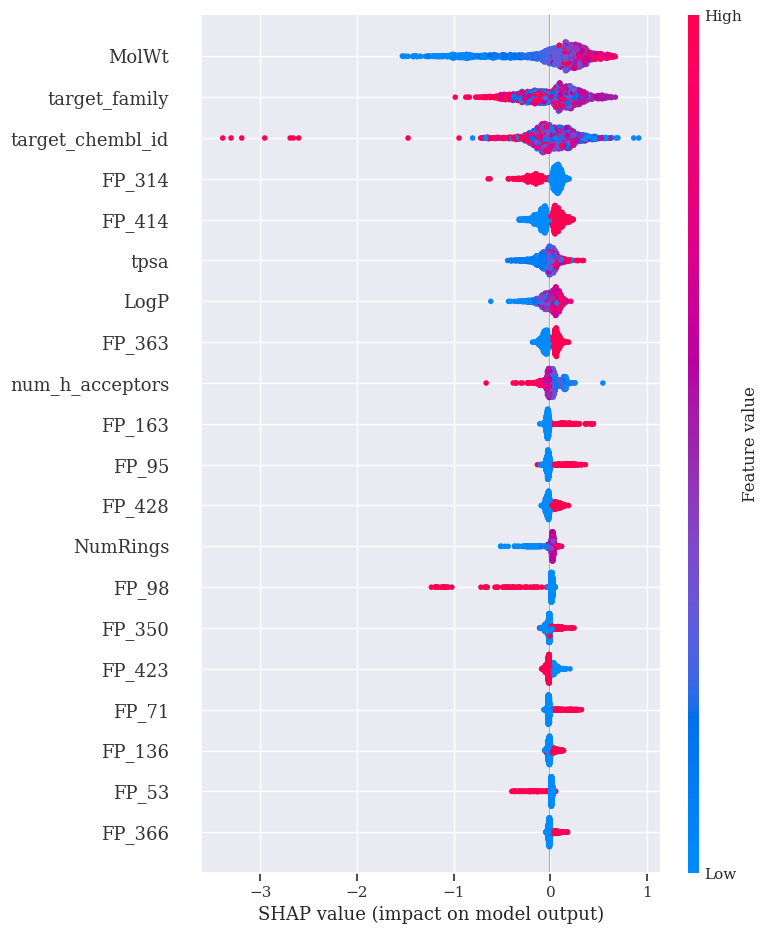

In [119]:
import shap

# Create SHAP explainer and compute SHAP values
explainer = shap.Explainer(best_model)
shap_values = explainer(X_val_fp)

# Summary plot (global feature importance)
shap.summary_plot(shap_values, X_val_fp, feature_names=X_val_fp.columns)

 98%|===================| 1689/1718 [00:31<00:00]       

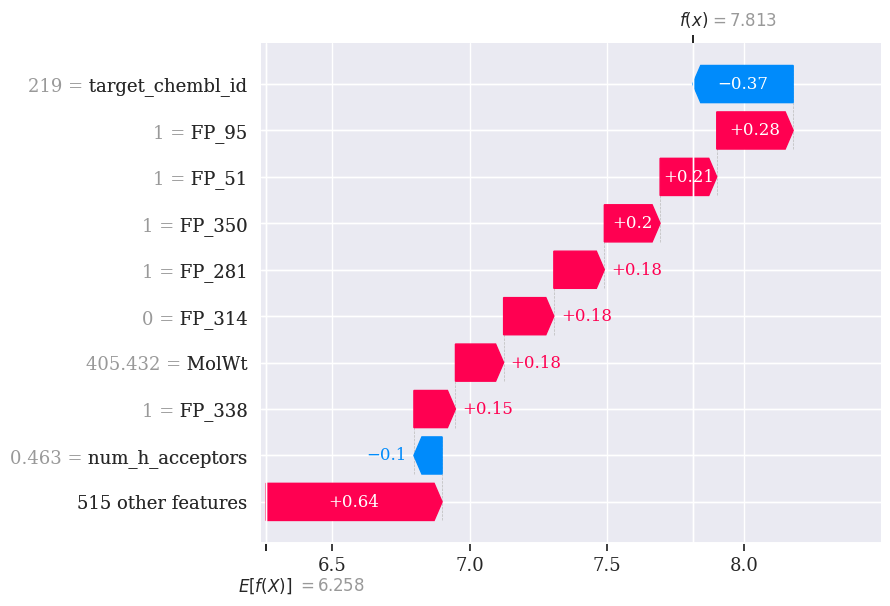

In [121]:
import shap

# Explain the model on the full dataset
explainer = shap.Explainer(best_model, X_val_fp)
shap_values = explainer(X_val_fp)

# Choose an instance (e.g., 0th sample)
sample_idx = 0

# Waterfall plot for one instance
shap.plots.waterfall(shap_values[sample_idx], max_display=10)

In [ ]:
import shap
import pandas as pd

# Compute SHAP values again (if needed)
explainer = shap.Explainer(best_model)
shap_values = explainer(X_train_fp)

# Get mean absolute SHAP values
shap_importance = pd.DataFrame({
    "feature": X_train_fp.columns,
    "shap_importance": np.abs(shap_values.values).mean(axis=0)
})

# Sort and select top 100
top_features = shap_importance.sort_values(by="shap_importance", ascending=False).head(100)["feature"].tolist()

# Subset original data
X_train_fp_selected = X_train_fp[top_features]
X_val_fp_selected = X_val_fp[top_features]

In [ ]:
xgb_fs = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=8,
    colsample_bytree=1.0,
    subsample=1.0,
    random_state=42
)

xgb_fs.fit(X_train_fp_selected, y_train_fp)
y_pred_fs = xgb_fs.predict(X_val_fp_selected)

print("R²:", r2_score(y_val_fp, y_pred_fs))
print("RMSE:", np.sqrt(mean_squared_error(y_val_fp, y_pred_fs)))
print("MAE:", mean_absolute_error(y_val_fp, y_pred_fs))

R²: 0.7400105951406208
RMSE: 0.8526865799191793
MAE: 0.6186229540245352


In [112]:
import numpy as np
import plotly.graph_objects as go

# Replace with your actual values
# y_val_fp = true pIC50 values
# y_pred_ridge_fp, y_pred_rf_fp, y_pred_mlp_fp, y_pred_fp = model predictions

# Create figure
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=y_val_fp, y=y_pred_best_ridge_fp_val, mode='markers',
    name='Ridge', marker=dict(color='gold', opacity=0.6)
))
fig.add_trace(go.Scatter(
    x=y_val_fp, y=y_pred_best_rf_fp_val, mode='markers',
    name='Random Forest', marker=dict(color='forestgreen', opacity=0.6)
))
fig.add_trace(go.Scatter(
    x=y_val_fp, y=y_pred_mlp_fp_val, mode='markers',
    name='MLP', marker=dict(color='blue', opacity=0.6)
))
fig.add_trace(go.Scatter(
    x=y_val_fp, y=y_pred_xg_fp_val, mode='markers',
    name='XGBoost', marker=dict(color='skyblue', opacity=0.6)
))

# Ideal prediction line
min_val = min(y_val_fp)
max_val = max(y_val_fp)
fig.add_trace(go.Scatter(
    x=[min_val, max_val], y=[min_val, max_val],
    mode='lines', line=dict(dash='dash', color='black'),
    name='Ideal'
))

# Layout
fig.update_layout(
    title='Actual vs Predicted pIC50 on Validation Set - All Models',
    xaxis_title='Actual pIC50',
    yaxis_title='Predicted pIC50',
    font=dict(family='Times New Roman', size=14),
    template='plotly_white',
    legend=dict(title=None)
)

fig.show()

In [114]:
import numpy as np
import plotly.graph_objects as go

# Replace with your actual values
# y_val_fp = true pIC50 values
# y_pred_ridge_fp, y_pred_rf_fp, y_pred_mlp_fp, y_pred_fp = model predictions

# Create figure
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=y_test_fp, y=y_pred_best_ridge_fp_test, mode='markers',
    name='Ridge', marker=dict(color='gold', opacity=0.6)
))
fig.add_trace(go.Scatter(
    x=y_test_fp, y=y_pred_best_rf_fp_test, mode='markers',
    name='Random Forest', marker=dict(color='forestgreen', opacity=0.6)
))
fig.add_trace(go.Scatter(
    x=y_test_fp, y=y_pred_mlp_fp_test, mode='markers',
    name='MLP', marker=dict(color='blue', opacity=0.6)
))
fig.add_trace(go.Scatter(
    x=y_test_fp, y=y_pred_xg_fp_test, mode='markers',
    name='XGBoost', marker=dict(color='skyblue', opacity=0.6)
))

# Ideal prediction line
min_val = min(y_test_fp)
max_val = max(y_test_fp)
fig.add_trace(go.Scatter(
    x=[min_val, max_val], y=[min_val, max_val],
    mode='lines', line=dict(dash='dash', color='black'),
    name='Ideal'
))

# Layout
fig.update_layout(
    title='Actual vs Predicted pIC50 on Test Set - All Models',
    xaxis_title='Actual pIC50',
    yaxis_title='Predicted pIC50',
    font=dict(family='Times New Roman', size=14),
    template='plotly_white',
    legend=dict(title=None)
)

fig.show()

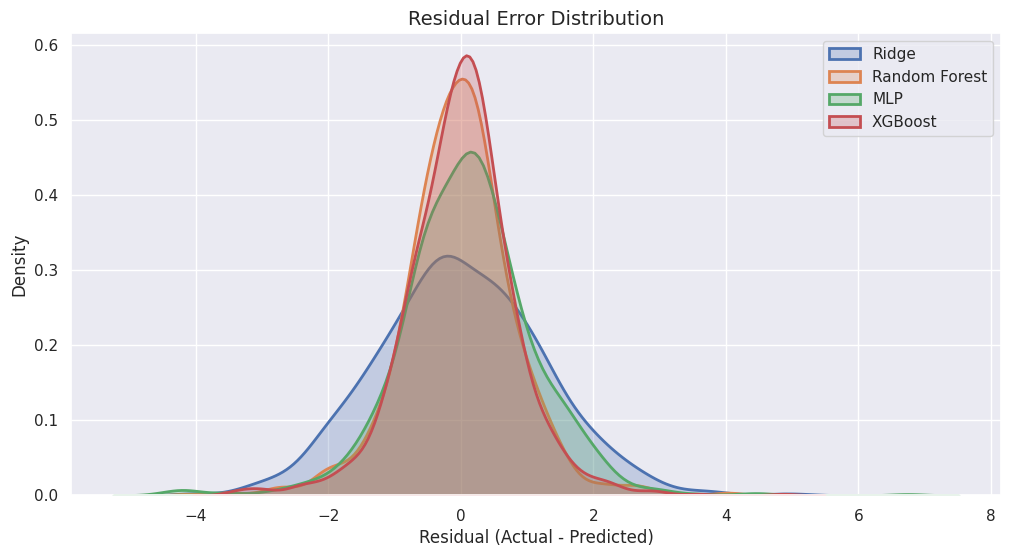

In [116]:
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.kdeplot(y_test_fp - y_pred_ridge_fp_test, label='Ridge', fill=True, linewidth=2)
sns.kdeplot(y_test_fp - y_pred_best_rf_fp_test, label='Random Forest', fill=True, linewidth=2)
sns.kdeplot(y_test_fp - y_pred_mlp_fp_test, label='MLP', fill=True, linewidth=2)
sns.kdeplot(y_test_fp - y_pred_xg_fp_test, label='XGBoost', fill=True, linewidth=2)

plt.title("Residual Error Distribution", fontsize=14)
plt.xlabel("Residual (Actual - Predicted)", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


# Classification of bioActivity

In [40]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [114]:
# Load dataset
df = pd.read_csv("chembl_with_512fingerprints.csv")
drop_cols = ['molecule_chembl_id', 'canonical_smiles', 'assay_chembl_id', 'standard_value']
df.drop(columns=drop_cols, inplace=True)

# Create binary classification target
df['activity_class'] = df['pIC50'].apply(lambda x: 1 if x >= 6 else 0)
X = df.drop(columns=['pIC50', 'activity_class'])
y_clf = df['activity_class']

# Step 1: Create the test set (1000 samples)
X_temp_clf, X_test_clf, y_temp_clf, y_test_clf = train_test_split(
    X, y_clf, test_size=1000
)

# Step 2: Split the remaining data into train and validation sets (e.g., 80-20 split)
X_train_clf, X_val_clf, y_train_clf, y_val_clf = train_test_split(X_temp_clf, y_temp_clf, test_size=0.2, random_state=42)

## Logistic Regression

In [115]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# Train model
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_clf, y_train_clf)

# Predict
y_pred_logreg = logreg.predict(X_test_clf)
y_proba_logreg = logreg.predict_proba(X_test_clf)[:, 1]

# Evaluate
print("\nLogistic Regression (Baseline)")
print(classification_report(y_test_clf, y_pred_logreg))
print("ROC AUC:", roc_auc_score(y_test_clf, y_proba_logreg))


Logistic Regression (Baseline)
              precision    recall  f1-score   support

           0       0.73      0.74      0.74       454
           1       0.78      0.78      0.78       546

    accuracy                           0.76      1000
   macro avg       0.76      0.76      0.76      1000
weighted avg       0.76      0.76      0.76      1000

ROC AUC: 0.8372141808265157


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [116]:
# Predict
y_pred_logreg_train = logreg.predict(X_train_clf)
y_proba_logreg_train = logreg.predict_proba(X_train_clf)[:, 1]

y_pred_logreg_val = logreg.predict(X_val_clf)
y_proba_logreg_val = logreg.predict_proba(X_val_clf)[:, 1]

In [117]:

# Evaluate
print("\nLogistic Regression Training(Baseline)")
print(classification_report(y_train_clf, y_pred_logreg_train))
print("ROC AUC:", roc_auc_score(y_train_clf, y_proba_logreg_train))

print("\nLogistic Regression Validation (Baseline)")
print(classification_report(y_val_clf, y_pred_logreg_val))
print("ROC AUC:", roc_auc_score(y_val_clf, y_proba_logreg_val))


Logistic Regression Training(Baseline)
              precision    recall  f1-score   support

           0       0.78      0.77      0.78      3027
           1       0.82      0.83      0.83      3845

    accuracy                           0.80      6872
   macro avg       0.80      0.80      0.80      6872
weighted avg       0.80      0.80      0.80      6872

ROC AUC: 0.8883166370459536

Logistic Regression Validation (Baseline)
              precision    recall  f1-score   support

           0       0.71      0.70      0.70       713
           1       0.79      0.80      0.79      1005

    accuracy                           0.75      1718
   macro avg       0.75      0.75      0.75      1718
weighted avg       0.75      0.75      0.75      1718

ROC AUC: 0.8376476662968467


## Random forest classifier

In [118]:
from sklearn.ensemble import RandomForestClassifier

# Train model
rf_model = RandomForestClassifier(n_estimators=300, max_depth=7, random_state=42)
rf_model.fit(X_train_clf, y_train_clf)

# Predict
y_pred_rf_test = rf_model.predict(X_test_clf)
y_proba_rf_test = rf_model.predict_proba(X_test_clf)[:, 1]

# Evaluate
print("\nRandom Forest Classifier")
print(classification_report(y_test_clf, y_pred_rf_test))
print("ROC AUC:", roc_auc_score(y_test_clf, y_proba_rf_test))


Random Forest Classifier
              precision    recall  f1-score   support

           0       0.79      0.69      0.74       454
           1       0.77      0.85      0.80       546

    accuracy                           0.78      1000
   macro avg       0.78      0.77      0.77      1000
weighted avg       0.78      0.78      0.77      1000

ROC AUC: 0.8631254941827629


In [119]:
# Predict
y_pred_rf_train = logreg.predict(X_train_clf)
y_proba_rf_train = logreg.predict_proba(X_train_clf)[:, 1]

y_pred_rf_val = logreg.predict(X_val_clf)
y_proba_rf_val = logreg.predict_proba(X_val_clf)[:, 1]# Evaluate
print("\nLogistic Regression Training(Baseline)")
print(classification_report(y_train_clf, y_pred_rf_train))
print("ROC AUC:", roc_auc_score(y_train_clf, y_proba_rf_train))

print("\nLogistic Regression Validation (Baseline)")
print(classification_report(y_val_clf, y_pred_rf_val))
print("ROC AUC:", roc_auc_score(y_val_clf, y_proba_rf_val))


Logistic Regression Training(Baseline)
              precision    recall  f1-score   support

           0       0.78      0.77      0.78      3027
           1       0.82      0.83      0.83      3845

    accuracy                           0.80      6872
   macro avg       0.80      0.80      0.80      6872
weighted avg       0.80      0.80      0.80      6872

ROC AUC: 0.8883166370459536

Logistic Regression Validation (Baseline)
              precision    recall  f1-score   support

           0       0.71      0.70      0.70       713
           1       0.79      0.80      0.79      1005

    accuracy                           0.75      1718
   macro avg       0.75      0.75      0.75      1718
weighted avg       0.75      0.75      0.75      1718

ROC AUC: 0.8376476662968467


## XGBoost Classifier

In [120]:
# Step 3: Classification with XGBoost
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score

clf_model = XGBClassifier(n_estimators=300, learning_rate=0.1, max_depth=7, use_label_encoder=False, eval_metric='logloss', random_state=42)
clf_model.fit(X_train_clf, y_train_clf)
y_pred_xg_clf = clf_model.predict(X_test_clf)
y_proba_xg_clf = clf_model.predict_proba(X_test_clf)[:, 1]

print("\nClassification Performance")
print(classification_report(y_test_clf, y_pred_xg_clf))
print("ROC AUC:", roc_auc_score(y_test_clf, y_proba_xg_clf))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[16:48:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.





Classification Performance
              precision    recall  f1-score   support

           0       0.85      0.85      0.85       454
           1       0.87      0.88      0.88       546

    accuracy                           0.86      1000
   macro avg       0.86      0.86      0.86      1000
weighted avg       0.86      0.86      0.86      1000

ROC AUC: 0.9393829371802942


In [123]:
# Predict
y_pred_xg_train = logreg.predict(X_train_clf)
y_proba_xg_train = logreg.predict_proba(X_train_clf)[:, 1]

y_pred_xg_val = logreg.predict(X_val_clf)
y_proba_xg_val = logreg.predict_proba(X_val_clf)[:, 1]# Evaluate
print("\nXGBoost Training")
print(classification_report(y_train_clf, y_pred_xg_train))
print("ROC AUC:", roc_auc_score(y_train_clf, y_proba_xg_train))

print("\nXGBoost Validation")
print(classification_report(y_val_clf, y_pred_xg_val))
print("ROC AUC:", roc_auc_score(y_val_clf, y_proba_xg_val))


XGBoost Training
              precision    recall  f1-score   support

           0       0.78      0.77      0.78      3027
           1       0.82      0.83      0.83      3845

    accuracy                           0.80      6872
   macro avg       0.80      0.80      0.80      6872
weighted avg       0.80      0.80      0.80      6872

ROC AUC: 0.8883166370459536

XGBoost Validation
              precision    recall  f1-score   support

           0       0.71      0.70      0.70       713
           1       0.79      0.80      0.79      1005

    accuracy                           0.75      1718
   macro avg       0.75      0.75      0.75      1718
weighted avg       0.75      0.75      0.75      1718

ROC AUC: 0.8376476662968467


## MLP classifier

In [124]:
from sklearn.neural_network import MLPClassifier

# Train MLP Classifier
mlp_model = MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', solver='adam',
                          learning_rate_init=0.001, max_iter=300, random_state=42)
mlp_model.fit(X_train_clf, y_train_clf)

# Predict
y_pred_mlp = mlp_model.predict(X_test_clf)
y_proba_mlp = mlp_model.predict_proba(X_test_clf)[:, 1]

# Evaluate
print("\nMLP Classifier")
print(classification_report(y_test_clf, y_pred_mlp))
print("ROC AUC:", roc_auc_score(y_test_clf, y_proba_mlp))


MLP Classifier
              precision    recall  f1-score   support

           0       0.78      0.80      0.79       454
           1       0.83      0.81      0.82       546

    accuracy                           0.81      1000
   macro avg       0.80      0.80      0.80      1000
weighted avg       0.81      0.81      0.81      1000

ROC AUC: 0.887003598457343


In [108]:
y_pred_mlp.shape

(1000,)

## Confusion Matrices for each model

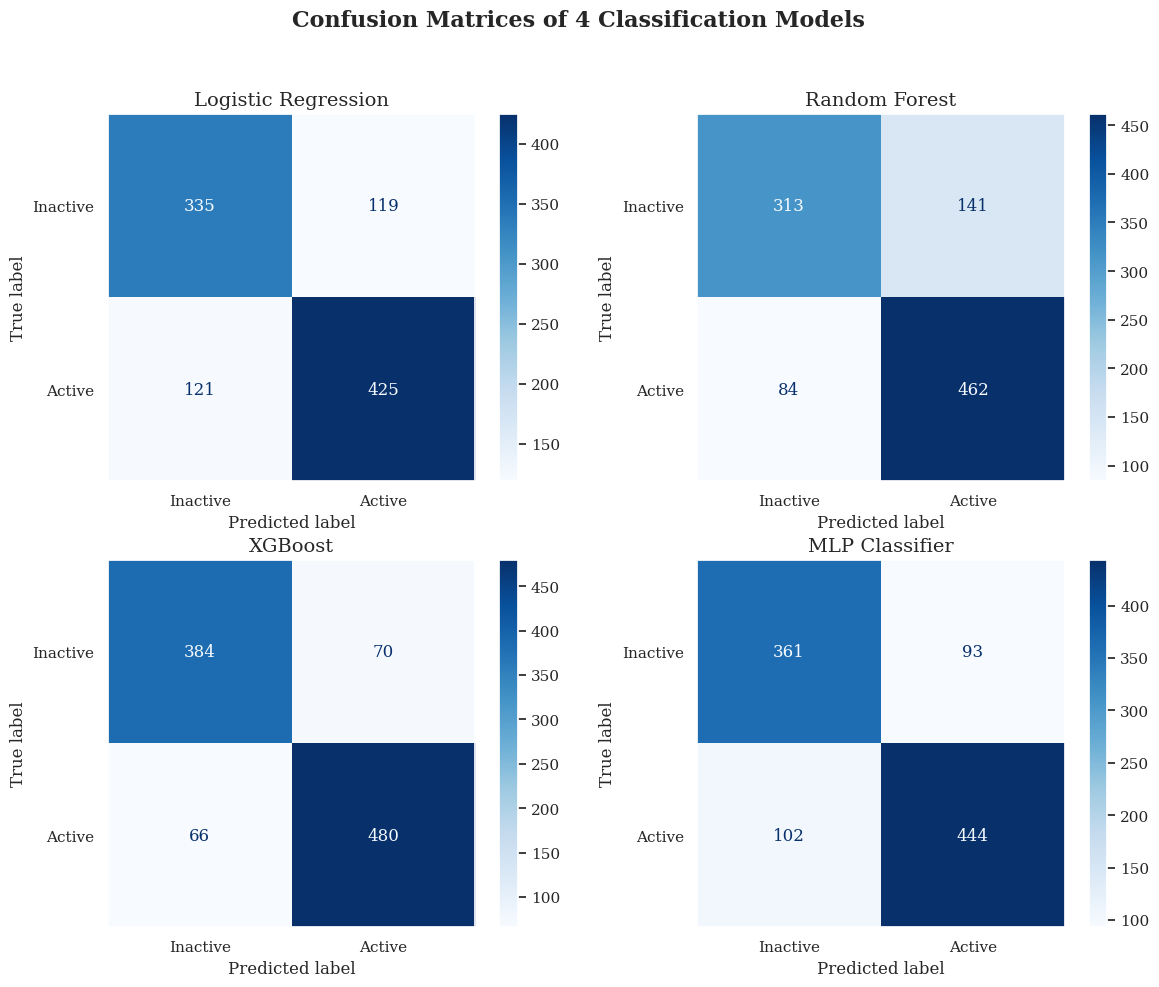

<Figure size 640x480 with 0 Axes>

In [109]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrices
cm_logreg = confusion_matrix(y_test_clf, y_pred_logreg)
cm_rf = confusion_matrix(y_test_clf, y_pred_rf_test)
cm_xgb = confusion_matrix(y_test_clf, y_pred_xg_clf)
cm_mlp = confusion_matrix(y_test_clf, y_pred_mlp)

# Set up figure and style
plt.rcParams.update({'font.family': 'serif'})
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot each confusion matrix with blue theme
ConfusionMatrixDisplay(cm_logreg, display_labels=["Inactive", "Active"]).plot(
    ax=axes[0, 0], cmap='Blues', values_format='d')
axes[0, 0].set_title("Logistic Regression", fontsize=14)

ConfusionMatrixDisplay(cm_rf, display_labels=["Inactive", "Active"]).plot(
    ax=axes[0, 1], cmap='Blues', values_format='d')
axes[0, 1].set_title("Random Forest", fontsize=14)

ConfusionMatrixDisplay(cm_xgb, display_labels=["Inactive", "Active"]).plot(
    ax=axes[1, 0], cmap='Blues', values_format='d')
axes[1, 0].set_title("XGBoost", fontsize=14)

ConfusionMatrixDisplay(cm_mlp, display_labels=["Inactive", "Active"]).plot(
    ax=axes[1, 1], cmap='Blues', values_format='d')
axes[1, 1].set_title("MLP Classifier", fontsize=14)

# Clean layout
for ax in axes.flat:
    ax.grid(False)

plt.suptitle("Confusion Matrices of 4 Classification Models", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
plt.savefig("confusion_matrix_grid.png", dpi=300, bbox_inches='tight')

In [111]:
y_test_clf.shape

(1000,)

(1000, 524)

In [161]:
import numpy as np
import plotly.graph_objects as go
import plotly.subplots as sp
from sklearn.metrics import confusion_matrix

# Compute confusion matrices
cms = {
    'Logistic Regression': confusion_matrix(y_test_clf, y_pred_logreg),
    'Random Forest': confusion_matrix(y_test_clf, y_pred_rf_test),
    'XGBoost': confusion_matrix(y_test_clf, y_pred_xg_clf),
    'MLP Classifier': confusion_matrix(y_test_clf, y_pred_mlp),
}

# Create a subplot grid
fig = sp.make_subplots(rows=2, cols=2, subplot_titles=list(cms.keys()))

# Labels for axes
x_labels = ["Inactive", "Active"]
y_labels = ["Inactive", "Active"]

# Add heatmaps and annotations
for i, (title, cm) in enumerate(cms.items()):
    row = i // 2 + 1
    col = i % 2 + 1

    z_text = [[str(cell) for cell in row_] for row_ in cm]

    heatmap = go.Heatmap(
        z=cm,
        x=x_labels,
        y=y_labels,
        text=z_text,
        texttemplate="%{text}",
        textfont={"size":14},
        colorscale='Blues',
        showscale=False
    )
    fig.add_trace(heatmap, row=row, col=col)
    fig.update_xaxes(title_text="Predicted", row=row, col=col)
    fig.update_yaxes(title_text="Actual", row=row, col=col)

# Layout
fig.update_layout(
    height=800,
    width=850,
    title_text="Confusion Matrices of 4 Classification Models",
    font=dict(family='Times New Roman', size=12),
    template='plotly_white'
)


fig.show()
fig.write_image("confusion_matrix_grid_plotly.png")

In [67]:
plt.savefig("confusion_matrix_grid.png", dpi=300, bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

In [133]:
import plotly.graph_objects as go
from sklearn.metrics import roc_curve, auc

# Initialize plot
fig = go.Figure()

# Dictionary of model names and predicted probabilities
models = {
    "Logistic": y_proba_logreg,
    "Random Forest": y_proba_rf_test,
    "XGBoost": y_proba_xg_clf,
    "MLP": y_proba_mlp
}

# Add ROC curve for each model
for name, y_proba in models.items():
    fpr, tpr, _ = roc_curve(y_test_clf, y_proba)
    roc_auc = auc(fpr, tpr)
    fig.add_trace(go.Scatter(
        x=fpr, y=tpr,
        mode='lines',
        name=f"{name} (AUC = {roc_auc:.2f})"
    ))

# Add reference line (diagonal)
fig.add_trace(go.Scatter(
    x=[0, 1], y=[0, 1],
    mode='lines',
    line=dict(dash='dash'),
    name='Random Classifier'
))

# Layout settings
fig.update_layout(
    title="ROC Curves for Bioactivity Classifiers",
    xaxis_title="False Positive Rate",
    yaxis_title="True Positive Rate",
    template="plotly_white",
    width=800,
    height=600,
    font=dict(family='Times New Roman', size=14),
    legend=dict(title=None)
)

fig.show()
fig.write_image("roc_curves.png")

In [137]:
import plotly.graph_objects as go
from sklearn.metrics import precision_recall_curve, average_precision_score

# Initialize plot
fig = go.Figure()

# Dictionary of model names and predicted probabilities
models = {
    "Logistic": y_proba_logreg,
    "Random Forest": y_proba_rf_test,
    "XGBoost": y_proba_xg_clf,
    "MLP": y_proba_mlp
}

# Add PR curve for each model
for name, y_proba in models.items():
    precision, recall, _ = precision_recall_curve(y_test_clf, y_proba)
    avg_precision = average_precision_score(y_test_clf, y_proba)
    fig.add_trace(go.Scatter(
        x=recall, y=precision,
        mode='lines',
        name=f"{name} (AP = {avg_precision:.2f})"
    ))

# Layout settings
fig.update_layout(
    title="Precision-Recall Curves for Bioactivity Classifiers",
    xaxis_title="Recall",
    yaxis_title="Precision",
    template="plotly_white",
    width=800,
    height=600
)

fig.show()
fig.write_image("pr_curves.png")

<ipython-input-138-9c33d76c9d1d>:4: FutureWarning:

The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.



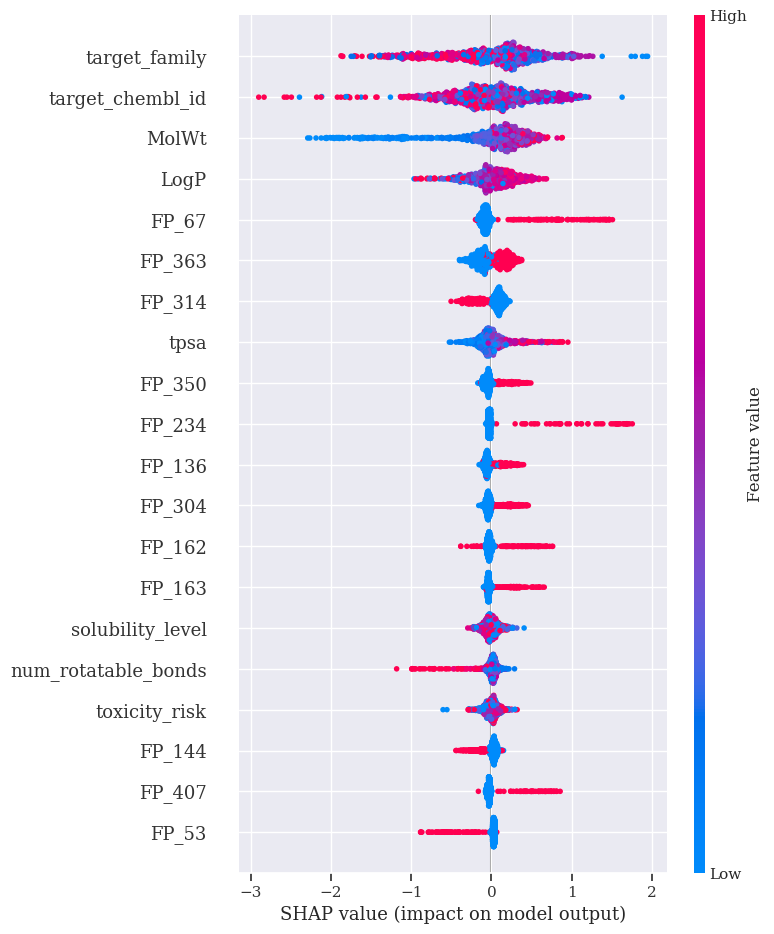

In [138]:
import shap
explainer = shap.Explainer(clf_model)  # XGBoost classifier
shap_values = explainer(X_test_clf)
shap.summary_plot(shap_values, X_test_clf, feature_names=X_test_clf.columns)

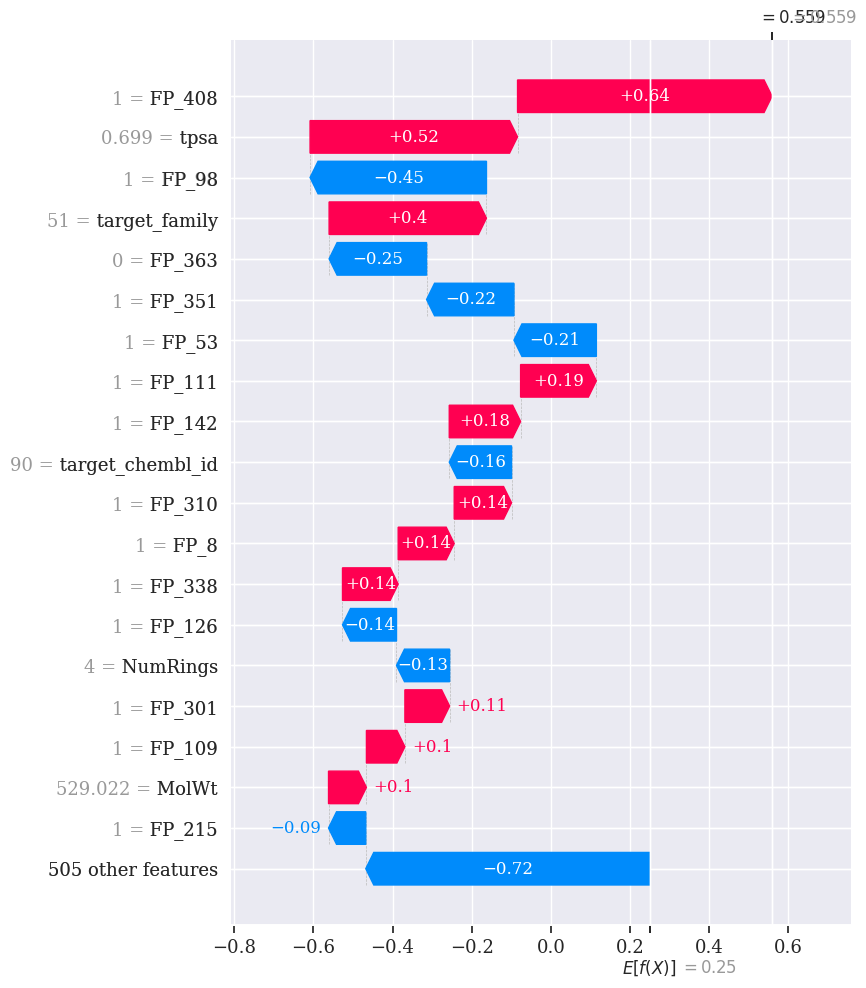

In [148]:
# Plot the waterfall plot for a specific instance
instance_index = 0
shap.plots.waterfall(shap_values[instance_index], max_display=20)


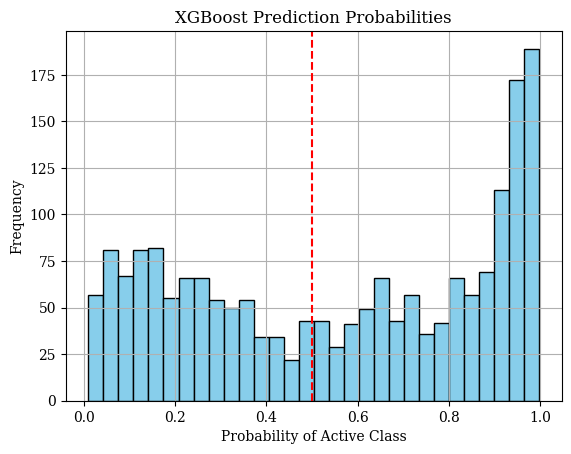

In [ ]:
plt.hist(y_proba_clf, bins=30, color='skyblue', edgecolor='black')
plt.axvline(0.5, color='red', linestyle='--')
plt.title("XGBoost Prediction Probabilities")
plt.xlabel("Probability of Active Class")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd
performance_df = pd.DataFrame({
    "Model": ["Logistic", "Random Forest", "XGBoost", "MLP"],
    "ROC AUC": [
        roc_auc_score(y_test_clf, y_proba_logreg),
        roc_auc_score(y_test_clf, y_proba_rf),
        roc_auc_score(y_test_clf, y_proba_clf),
        roc_auc_score(y_test_clf, y_proba_mlp)
    ]
})
display(performance_df)


Model   ROC AUC
0       Logistic  0.868612
1  Random Forest  0.882427
2        XGBoost  0.927769
3            MLP  0.898054